# 0.0) Import das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import warnings
import requests
import random
import pickle
import json
import math
import re
import os

from boruta import BorutaPy
from scipy import stats as ss
from IPython.display import Image
from datetime import datetime, timedelta
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

sns.set_theme()
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (24, 12)

### 0.1) Funções Auxiliares

In [3]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def ml_error(label, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return pd.DataFrame({'Model Name': label, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])

def plot_2_var_corr(df, col1, col2):
    x = sns.heatmap( df[[col1, col2]].corr( method='pearson' ), annot=True );
    #bottom, top = x.get_ylim()
    #x.set_ylim( bottom+0.5, top-0.5 );
    
    return x

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def cross_validation(df, model_name, model, kfold, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    min_date = df.date.min()
    max_date = df.date.max()

    for k in reversed(range(1, kfold+1)):
        training_set = df.loc[df['date'] < max_date - timedelta(days=k*6*7), :]
        validation_set = df.loc[(df['date'] >= max_date - timedelta(days=k*6*7)) & (df['date'] <= max_date - timedelta(days=(k-1)*6*7))]

        # train
        x_train = training_set.drop(columns=['sales', 'date'])
        y_train = training_set['sales']

        # validation
        x_val = validation_set.drop(columns=['sales', 'date'])
        y_val = validation_set['sales']

        # model
        m = model.fit(x_train, y_train)

        # prediction
        yhat = m.predict(x_val)

        # result
        result = ml_error(model_name, np.expm1(y_val), np.expm1(yhat))

        mae_list.append(result['MAE'])
        mape_list.append(result['MAPE'])
        rmse_list.append(result['RMSE'])

    return pd.DataFrame({
        'Model Name': model_name, 
        'MAE': f'{np.mean(mae_list):.2f} +/- {np.std(mae_list):.2f}', 
        'MAPE': f'{np.mean(mape_list):.2f} +/- {np.std(mape_list):.2f}', 
        'RMSE': f'{np.mean(rmse_list):.2f} +/- {np.std(rmse_list):.2f}'}
    , index=[0])

### 0.2) Coleta dos Dados

In [4]:
df_train = pd.read_csv('data/train.csv')
df_store = pd.read_csv('data/store.csv')

In [5]:
df_raw = df_train.merge(df_store, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


# 1.0) Descrição dos Dados

In [6]:
df1 = df_raw.copy()

In [7]:
print(f'Total de linhas: {df1.shape[0]:,}')
print(f'Total de colunas: {df1.shape[1]}')

Total de linhas: 1,017,209
Total de colunas: 18


### 1.1) Renomear colunas

Renomear as colunas para um formato padrão e mais legível.

In [8]:
for col in df1.columns:
    print(col, end=' | ')

Store | DayOfWeek | Date | Sales | Customers | Open | Promo | StateHoliday | SchoolHoliday | StoreType | Assortment | CompetitionDistance | CompetitionOpenSinceMonth | CompetitionOpenSinceYear | Promo2 | Promo2SinceWeek | Promo2SinceYear | PromoInterval | 

In [9]:
# rename columns 
snakecase = lambda x: inflection.underscore( x )

df1.columns = list( map( snakecase, df1.columns.values ) )

### 1.2) Tipos dos Dados

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.3) Valores NAs

Existem diversas colunas com valores nulos, neste primeiro ciclo, irei imputá-los com zero apenas.

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.4) Tratando valores NAs

In [12]:
df1['competition_distance'].fillna(0, inplace=True)
df1['promo_interval'].fillna(0, inplace=True)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].weekofyear if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [13]:
df1.isna().sum().sum()

0

Agora que não possuímos mais valores nulos em nosso dataframe, podemos então prosseguir com os próximos passos.

### 1.5) Corrigindo Tipos dos Dados

Aqui estão algumas transformações nos tipos dos dados para auxiliar posteriormente na criação de gráficos, na descrição estatística e por serem mais convenientes que os anteriores.

In [14]:
# competition_open_since_year -> int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# competition_open_since_month -> int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# promo2_since_year -> int
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# promo2_since_week -> int
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

### 1.6) Linhas duplicadas

In [15]:
df1.duplicated().sum()

0

### 1.7) Estatísticas de Resumo

In [16]:
num_attr, cat_attr = df1.select_dtypes(include=['int', 'float']), df1.select_dtypes(exclude=['int', 'float'])

**Variáveis Numéricas**

In [17]:
num_stats = pd.concat([num_attr.describe().T.drop(columns=['count']), pd.DataFrame({'skew': num_attr.skew(), 'kurtosis': num_attr.kurtosis()})], axis=1)
num_stats

,mean,std,min,25%,50%,75%,max,skew,kurtosis
store,558.43,321.91,1.00,280.00,558.00,838.00,1115.00,-0.00,-1.20
day_of_week,4.00,2.00,1.00,2.00,4.00,6.00,7.00,0.00,-1.25
sales,5773.82,3849.93,0.00,3727.00,5744.00,7856.00,41551.00,0.64,1.78
customers,633.15,464.41,0.00,405.00,609.00,837.00,7388.00,1.60,7.09
open,0.83,0.38,0.00,1.00,1.00,1.00,1.00,-1.76,1.09
promo,0.38,0.49,0.00,0.00,0.00,1.00,1.00,0.49,-1.76
school_holiday,0.18,0.38,0.00,0.00,0.00,0.00,1.00,1.68,0.82
competition_distance,5415.98,7710.25,0.00,700.00,2320.00,6880.00,75860.00,2.93,13.02
competition_open_since_month,6.79,3.31,1.00,4.00,7.00,10.00,12.00,-0.04,-1.23
competition_open_since_year,2010.32,5.52,1900.00,2008.00,2012.00,2014.00,2015.00,-7.24,124.07


**Variáveis Categóricas**

In [18]:
cat_stats = pd.concat([cat_attr.describe().T.drop(columns=['count']), \
    pd.DataFrame({'skew': cat_attr.skew(), 'kurtosis': cat_attr.kurtosis()})], axis=1)
cat_stats

,unique,top,freq,first,last,skew,kurtosis
date,942,2015-07-31 00:00:00,1115,2013-01-01,2015-07-31,NaN,NaN
state_holiday,5,0,855087,NaT,NaT,NaN,NaN
store_type,4,a,551627,NaT,NaT,NaN,NaN
assortment,3,a,537445,NaT,NaT,NaN,NaN
promo_interval,4.00,0.00,508031.00,NaT,NaT,NaN,NaN


# 2.0) Feature Engineering

In [19]:
df2 = df1.copy()

### 2.1) Mindmap de Hipóteses

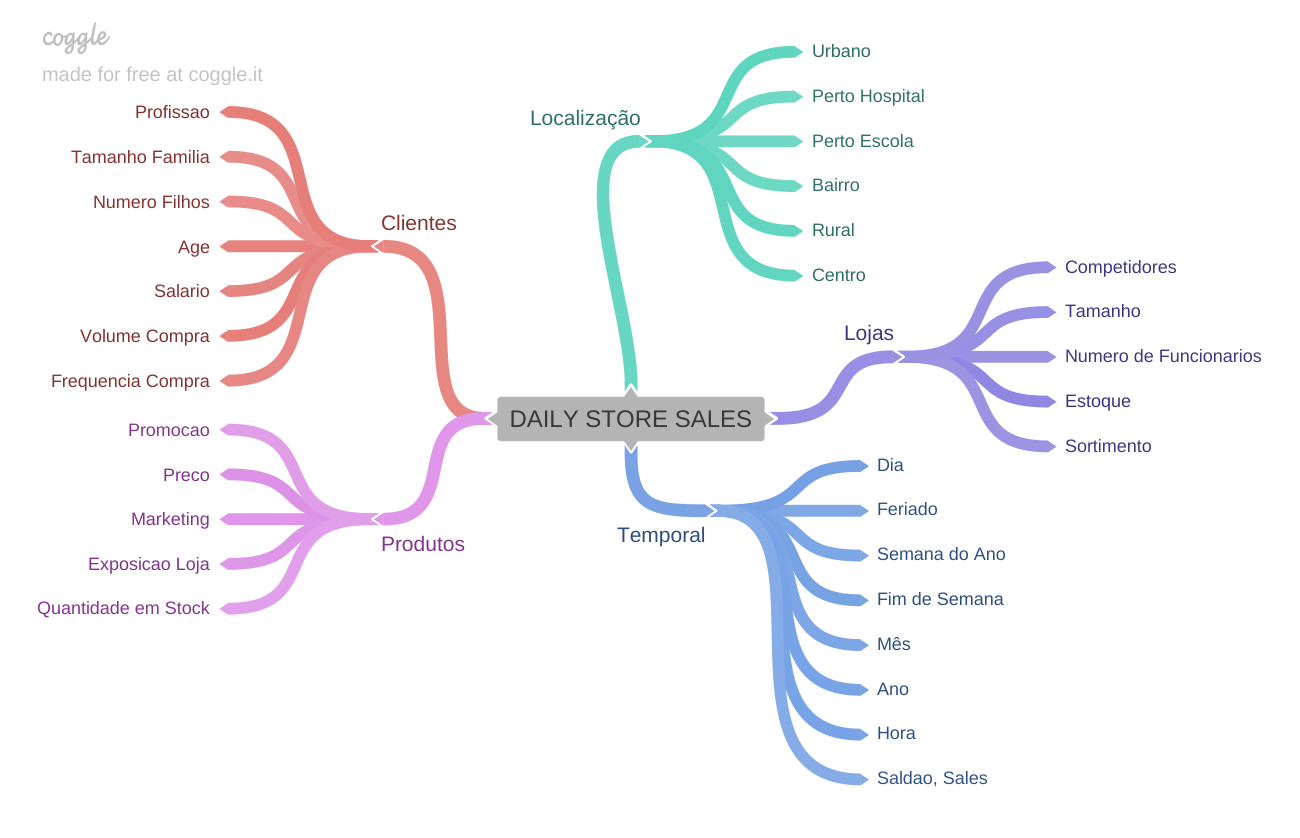

In [20]:
Image('img/DAILY_STORE_SALES.png')

### 2.2) Criação das Hipóteses

#### 2.2.1. Hipoteses Loja
1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

#### 2.2.2. Hipoteses Produto
1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.2.3. Hipoteses Tempo
1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### 2.3) Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

### 2.4) Feature Engineering

In [21]:
# day
df2['day'] = df2['date'].dt.day

# month
df2['month'] = df2['date'].dt.month

# year
df2['year'] = df2['date'].dt.year

# week_of_year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# assortment
assortment_map = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df2['assortment'] = df2['assortment'].map(assortment_map)

# state_holiday
state_holiday_map = { 'a': 'public holiday', 'b': 'Easter holiday', 'c': 'Christmas', '0': 'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_map)

# competition_open_since
df2['competition_open_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'] if x['competition_open_since_year'] != 0 else x['date'].year, \
    month=x['competition_open_since_month'] if x['competition_open_since_month'] != 0 else x['date'].month, day=1), axis=1)

# competition_duration
df2['competition_duration'] = df2.apply(lambda x: np.round((x['date'] - x['competition_open_since']).days / 30).astype(int) if x['date'] > x['competition_open_since']  else 0, axis=1)

# promo2_since
df2['promo2_since'] = df2.apply(lambda x: f"{x['promo2_since_year']}-{x['promo2_since_week']}" if  x['promo2_since_year'] != 0 else x['date'].strftime('%Y-%W'), axis=1)

df2['promo2_since'] = df2['promo2_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo2_since'] ) / 7 ).apply(lambda x: x.days ).astype( int )

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', \
    8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['month_map'] = df2['month'].map( month_map )
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 \
    if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ).astype('bool')
df2.loc[(df2['promo_time_week'] == 0) & (df2['is_promo'] == 1), 'promo_time_week'] = 1

# 3.0) Filtragem de Variáveis

In [22]:
df3 = df2.copy()

### 3.1) Filtragem das Linhas

In [23]:
df3 = df3.query('open == True & sales > 0')

### 3.2) Seleção das Colunas

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
#cols_drop_2 = ['customers', 'open', 'competition_open_since_month',
#       'competition_open_since_year', 'promo2_since_week',
#       'promo2_since_year', 'promo_interval', 'month_map']

df3.drop(columns=cols_drop, inplace=True)

# 4.0) Análise Exploratória de Dados

In [25]:
df4 = df3.copy()

### 4.1) Análise Univariada

#### 4.1.2) Variável Target

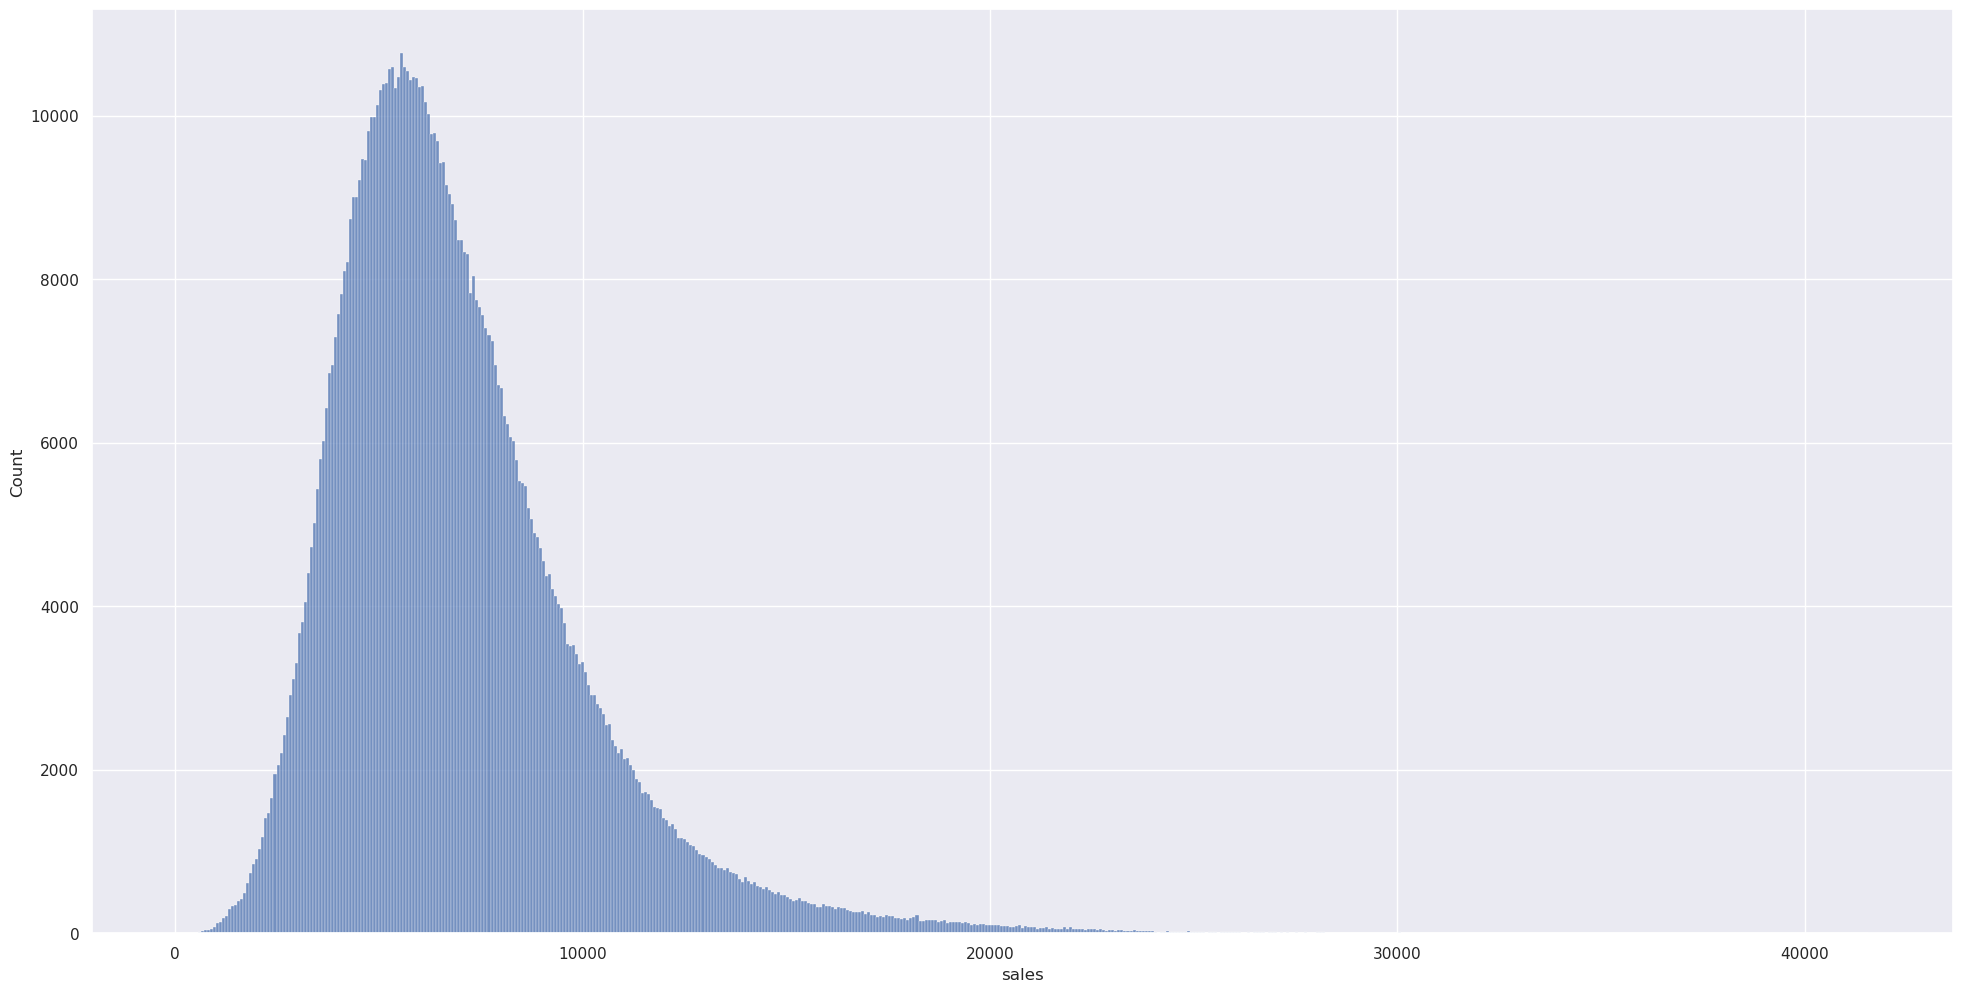

In [26]:
sns.histplot(df4['sales']);

#### 4.1.2) Variáveis Numéricas

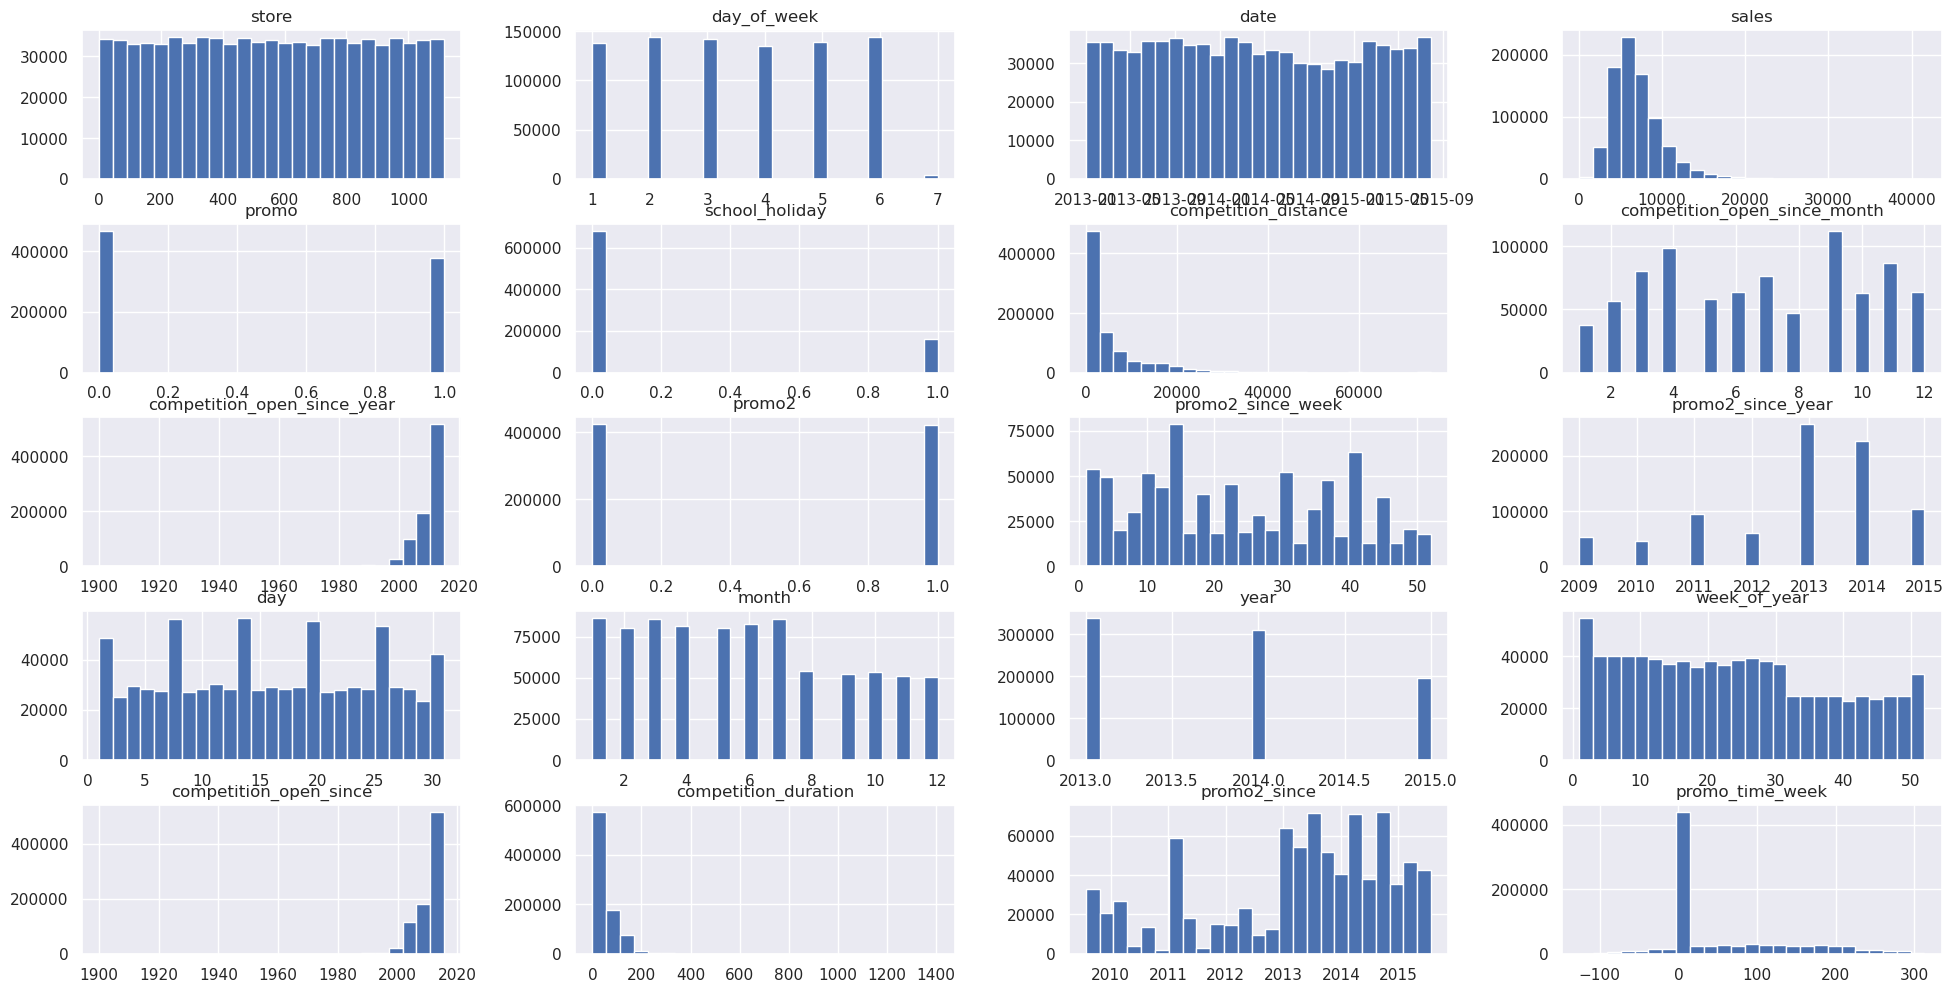

In [27]:
num_attr = df4.select_dtypes(include=[int, float, 'datetime64[ns]'])
num_attr.hist(bins=25);

#### 4.1.3) Variáveis Categóricas

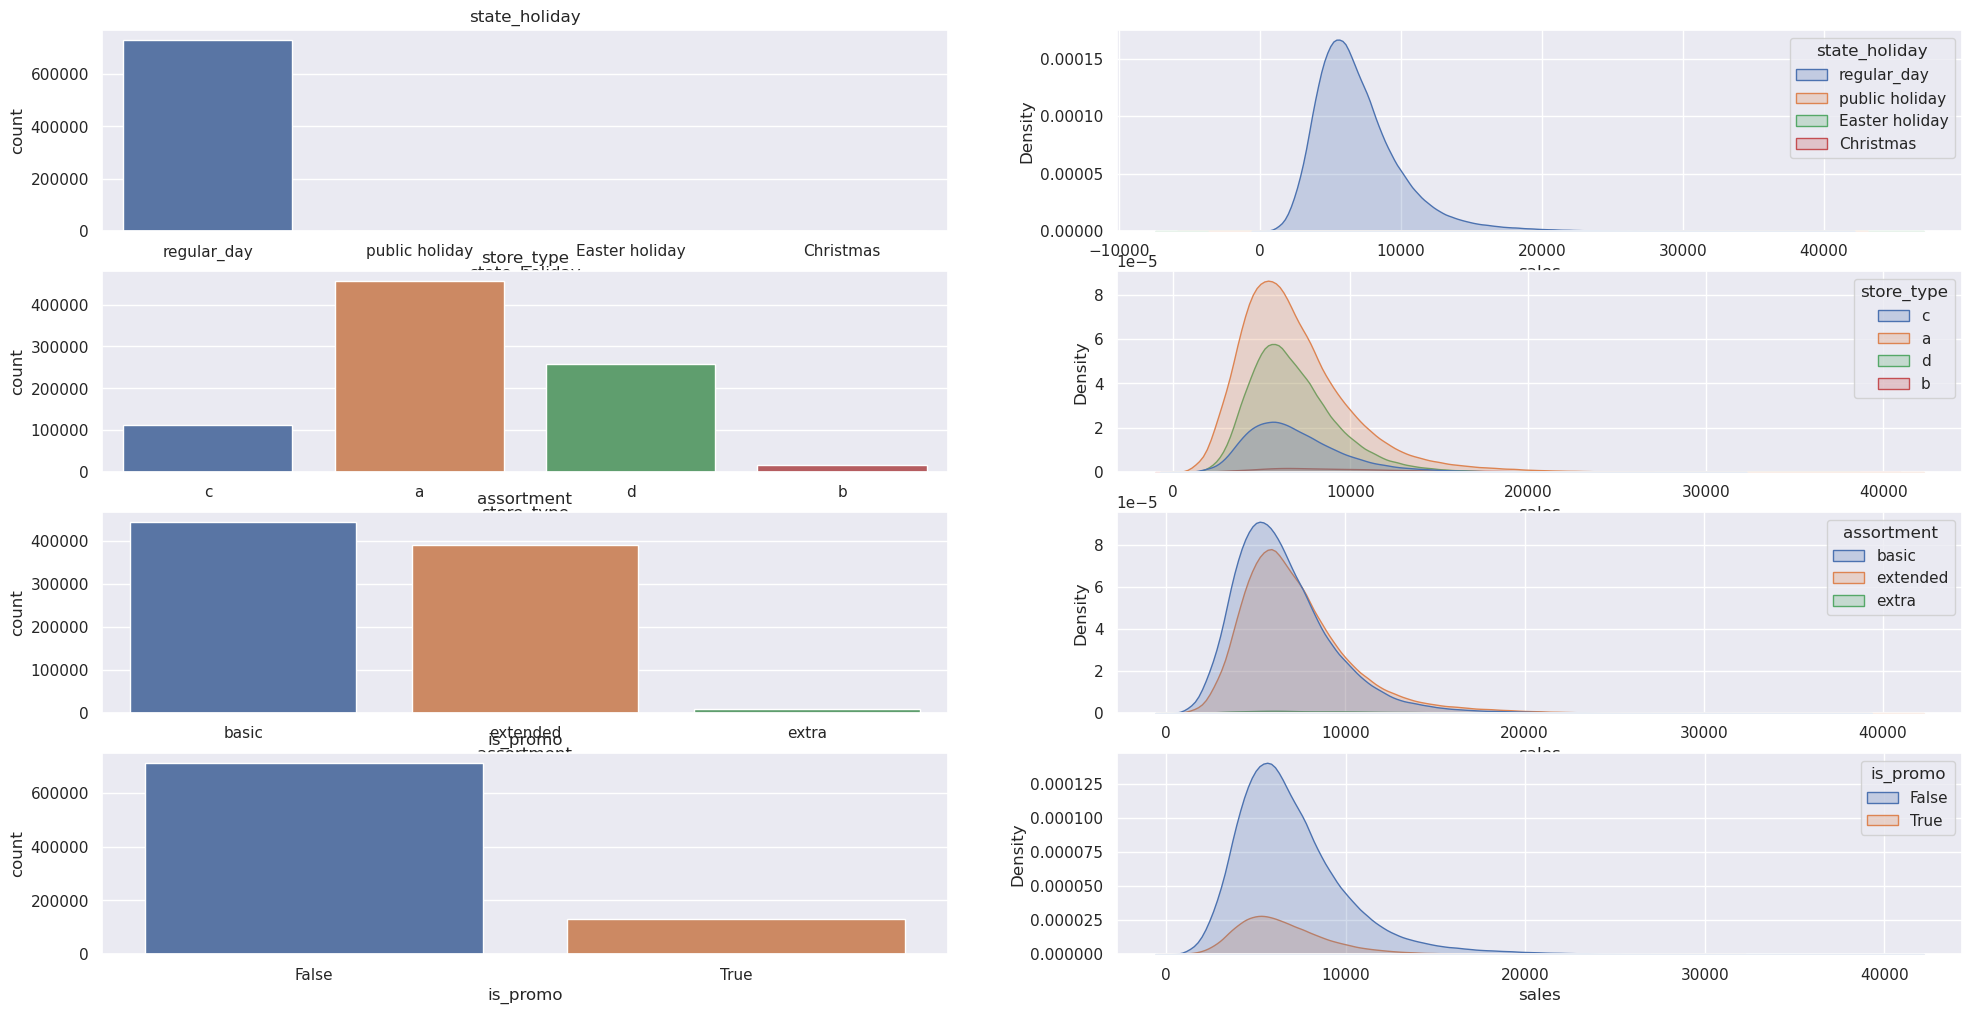

In [28]:
fig, ax = plt.subplots(4, 2)

# state_holiday
sns.countplot(data=df4, x='state_holiday', ax=ax[0, 0])

sns.kdeplot(data=df4, x='sales', hue='state_holiday', fill=True, ax=ax[0, 1])
ax[0, 0].set_title('state_holiday', fontsize=12)

# store_type
sns.countplot(data=df4, x='store_type', ax=ax[1, 0])

sns.kdeplot(data=df4, x='sales', hue='store_type', fill=True, ax=ax[1, 1])
ax[1, 0].set_title('store_type', fontsize=12)

# assortment
sns.countplot(data=df4, x='assortment', ax=ax[2, 0])

sns.kdeplot(data=df4, x='sales', hue='assortment', fill=True, ax=ax[2, 1])
ax[2, 0].set_title('assortment', fontsize=12)

# is_promo
sns.countplot(data=df4, x='is_promo', ax=ax[3, 0])

sns.kdeplot(data=df4, x='sales', hue='is_promo', fill=True, ax=ax[3, 1])
ax[3, 0].set_title('is_promo', fontsize=12)

plt.show()

### 4.2) Análise Bivariada

#### H1. Lojas com maior sortimentos deveriam vender mais.

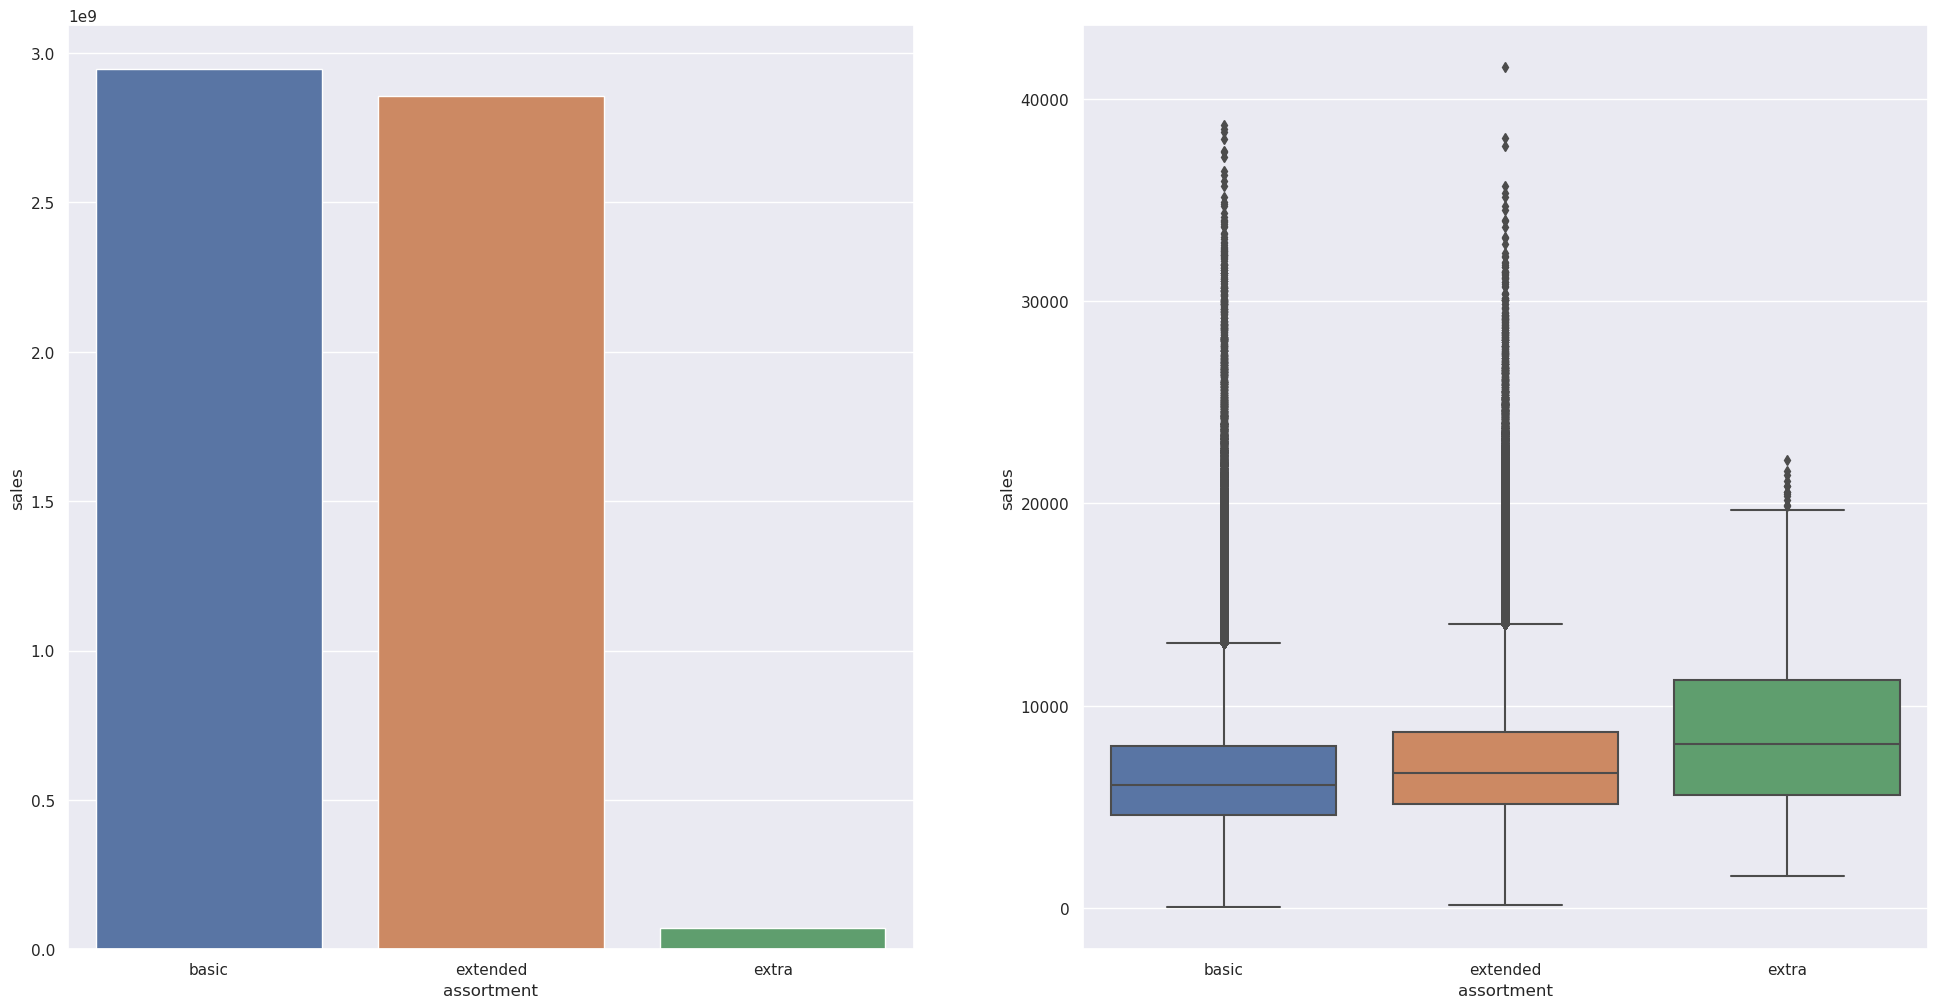

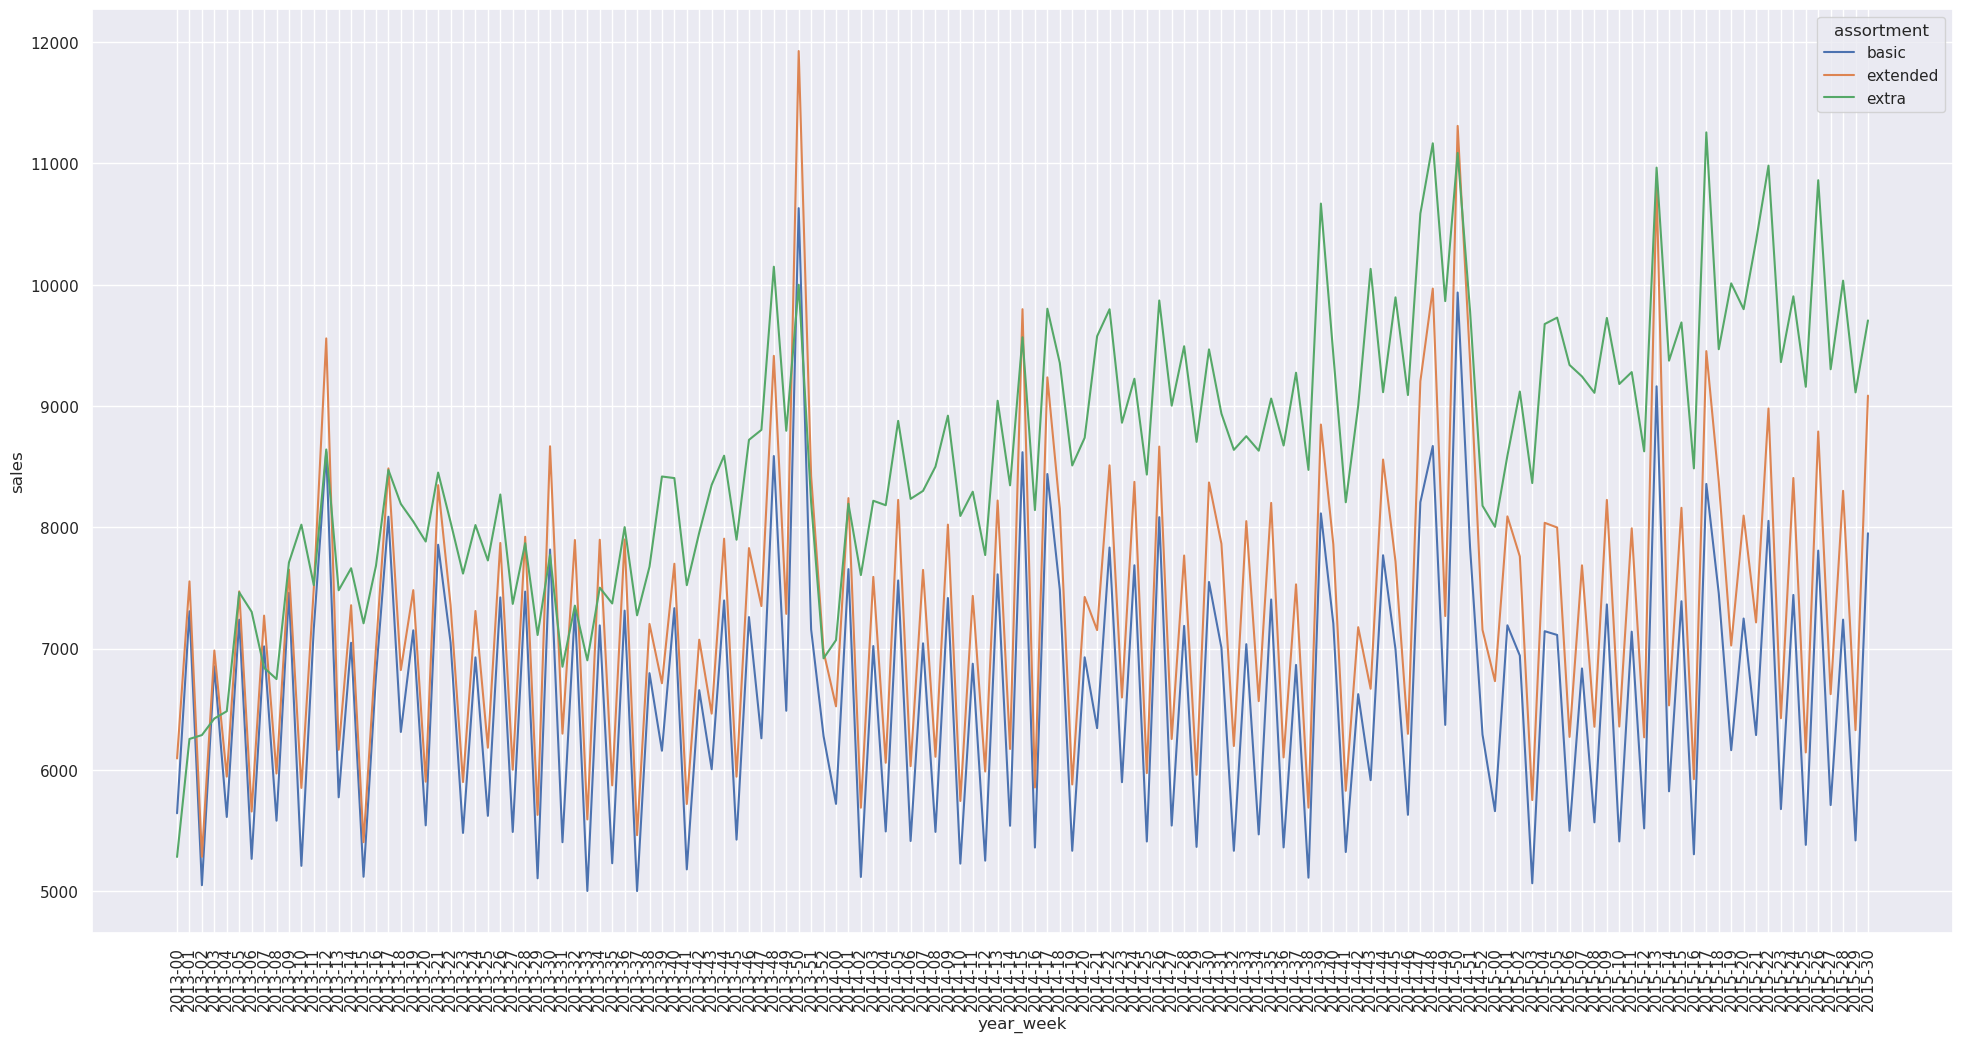

In [29]:
df_h1 = df4.groupby('assortment').agg({'sales': 'sum'}).reset_index()
df_h1_2 = df4.groupby(['year_week', 'assortment']).agg({'sales': 'mean'}).reset_index()

fig, ax = plt.subplots(1, 2)

sns.barplot(data=df_h1, x='assortment', y='sales', ax=ax[0])
sns.boxplot(data=df4, y='sales', x='assortment', ax=ax[1])

fig, ax2 = plt.subplots()

sns.lineplot(data=df_h1_2, x='year_week', y='sales', hue='assortment', ax=ax2)
ax2.set_xticklabels(df_h1_2['year_week'].unique(), rotation=90)

plt.show()

#### H2. Lojas com competidores mais próximos deveriam vender menos.

In [30]:
df_h2 = df4.loc[(df4['competition_duration'] > 0) & (df4['competition_distance'] > 0), ['competition_duration', 'competition_distance', 'sales']]
df_h2['bins'] = pd.qcut(df_h2.loc[(df_h2['competition_duration'] > 0) & (df_h2['competition_distance'] > 0), 'competition_distance'], 20, precision=1)

df_h2_1 = df_h2.groupby('bins').agg({'sales': 'mean'}).reset_index()

In [31]:
df4.loc[df4['competition_distance'] == 0, ['competition_duration', 'competition_distance', 'sales']].shape

(2186, 3)

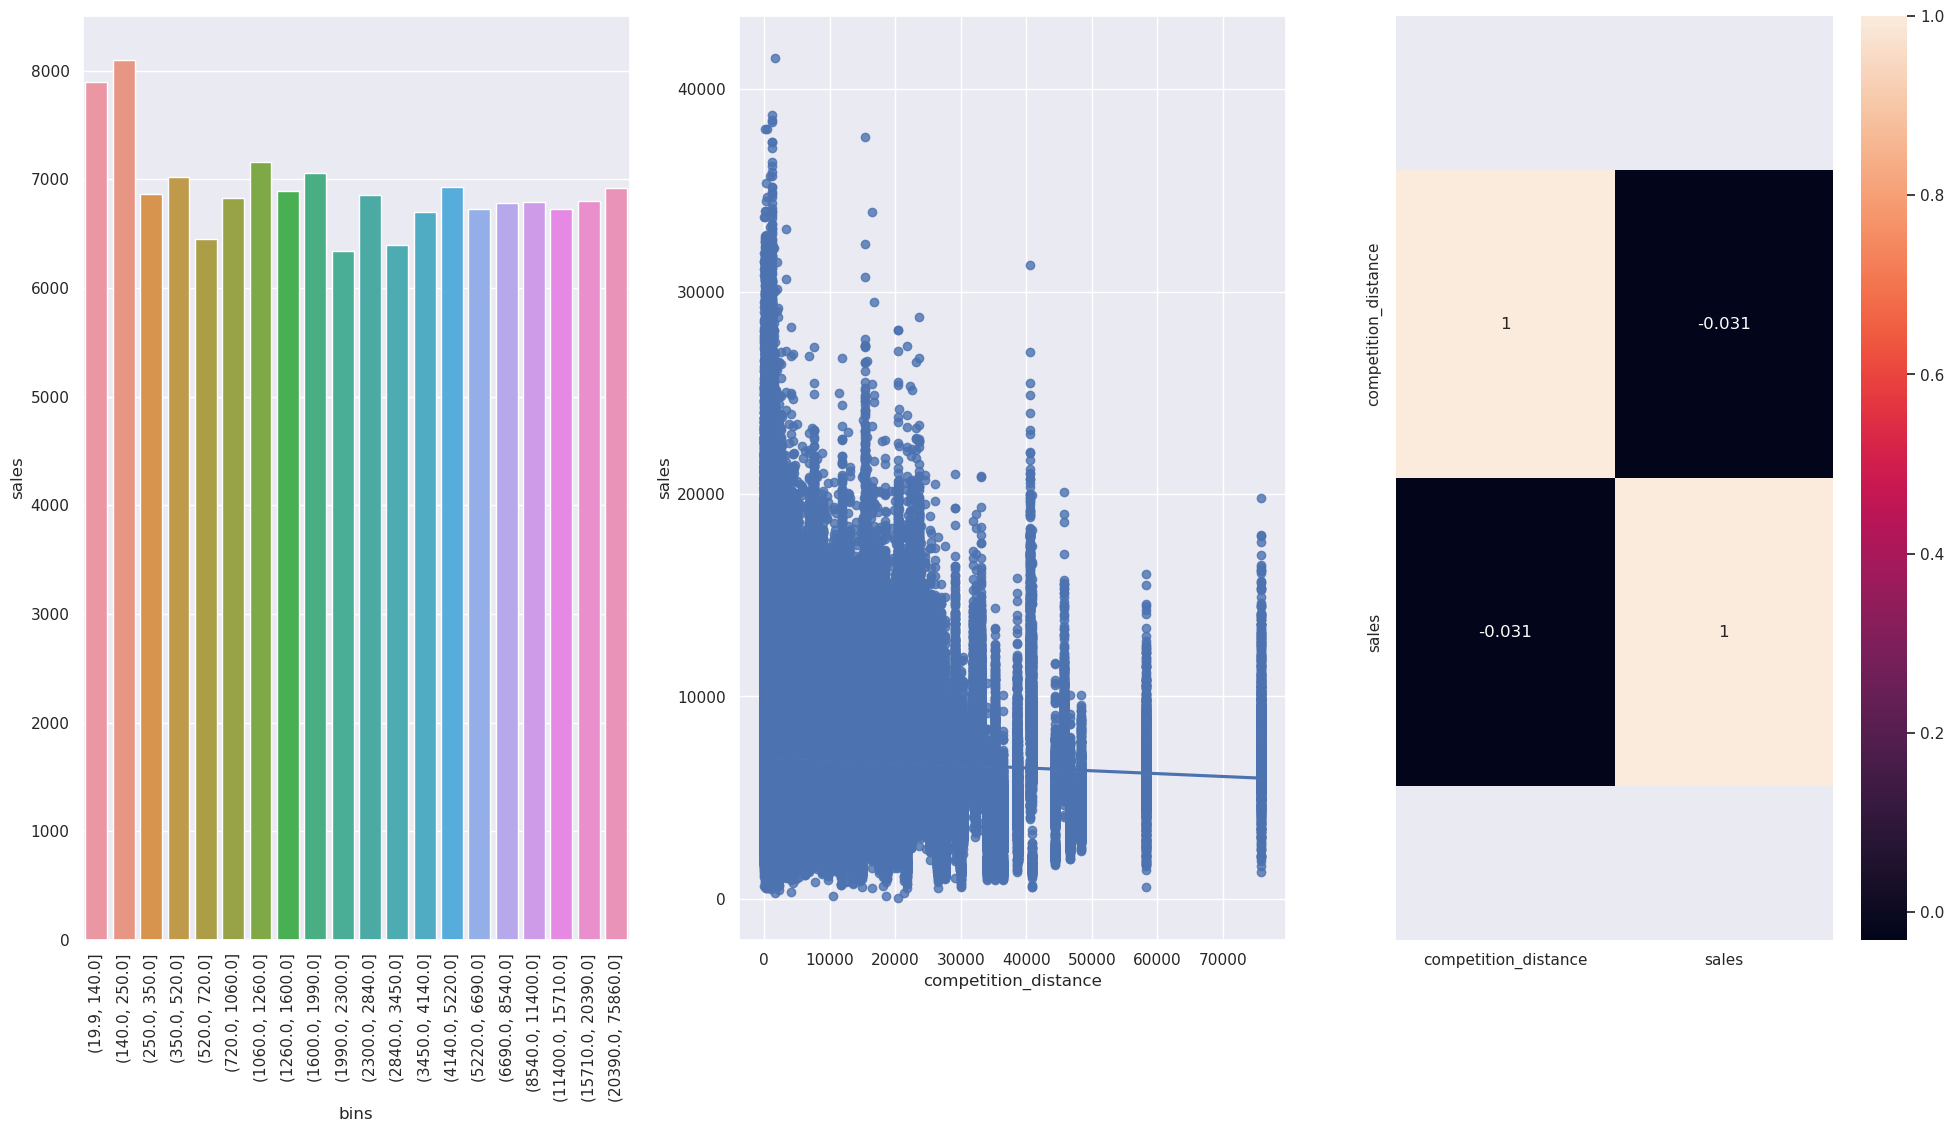

In [32]:
fig, ax = plt.subplots(1, 3)

sns.barplot(data=df_h2_1, x='bins', y='sales', ax=ax[0])
ax[0].set_xticklabels(df_h2_1['bins'], rotation=90)

sns.regplot(data=df4, x='competition_distance', y='sales', ci=False, ax=ax[1])

x = sns.heatmap( df_h2[['competition_distance', 'sales']].corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

plt.show()

#### H3. Lojas com competidores à mais tempo deveriam vender mais.

In [33]:
df_h3 = df4[['competition_duration', 'sales']]
df_h3['bins'] = pd.qcut(df_h3['competition_duration'], 15, duplicates='drop', precision=1)

df_h3_1 = df_h3.groupby('bins').agg({'sales': 'mean'}).reset_index()

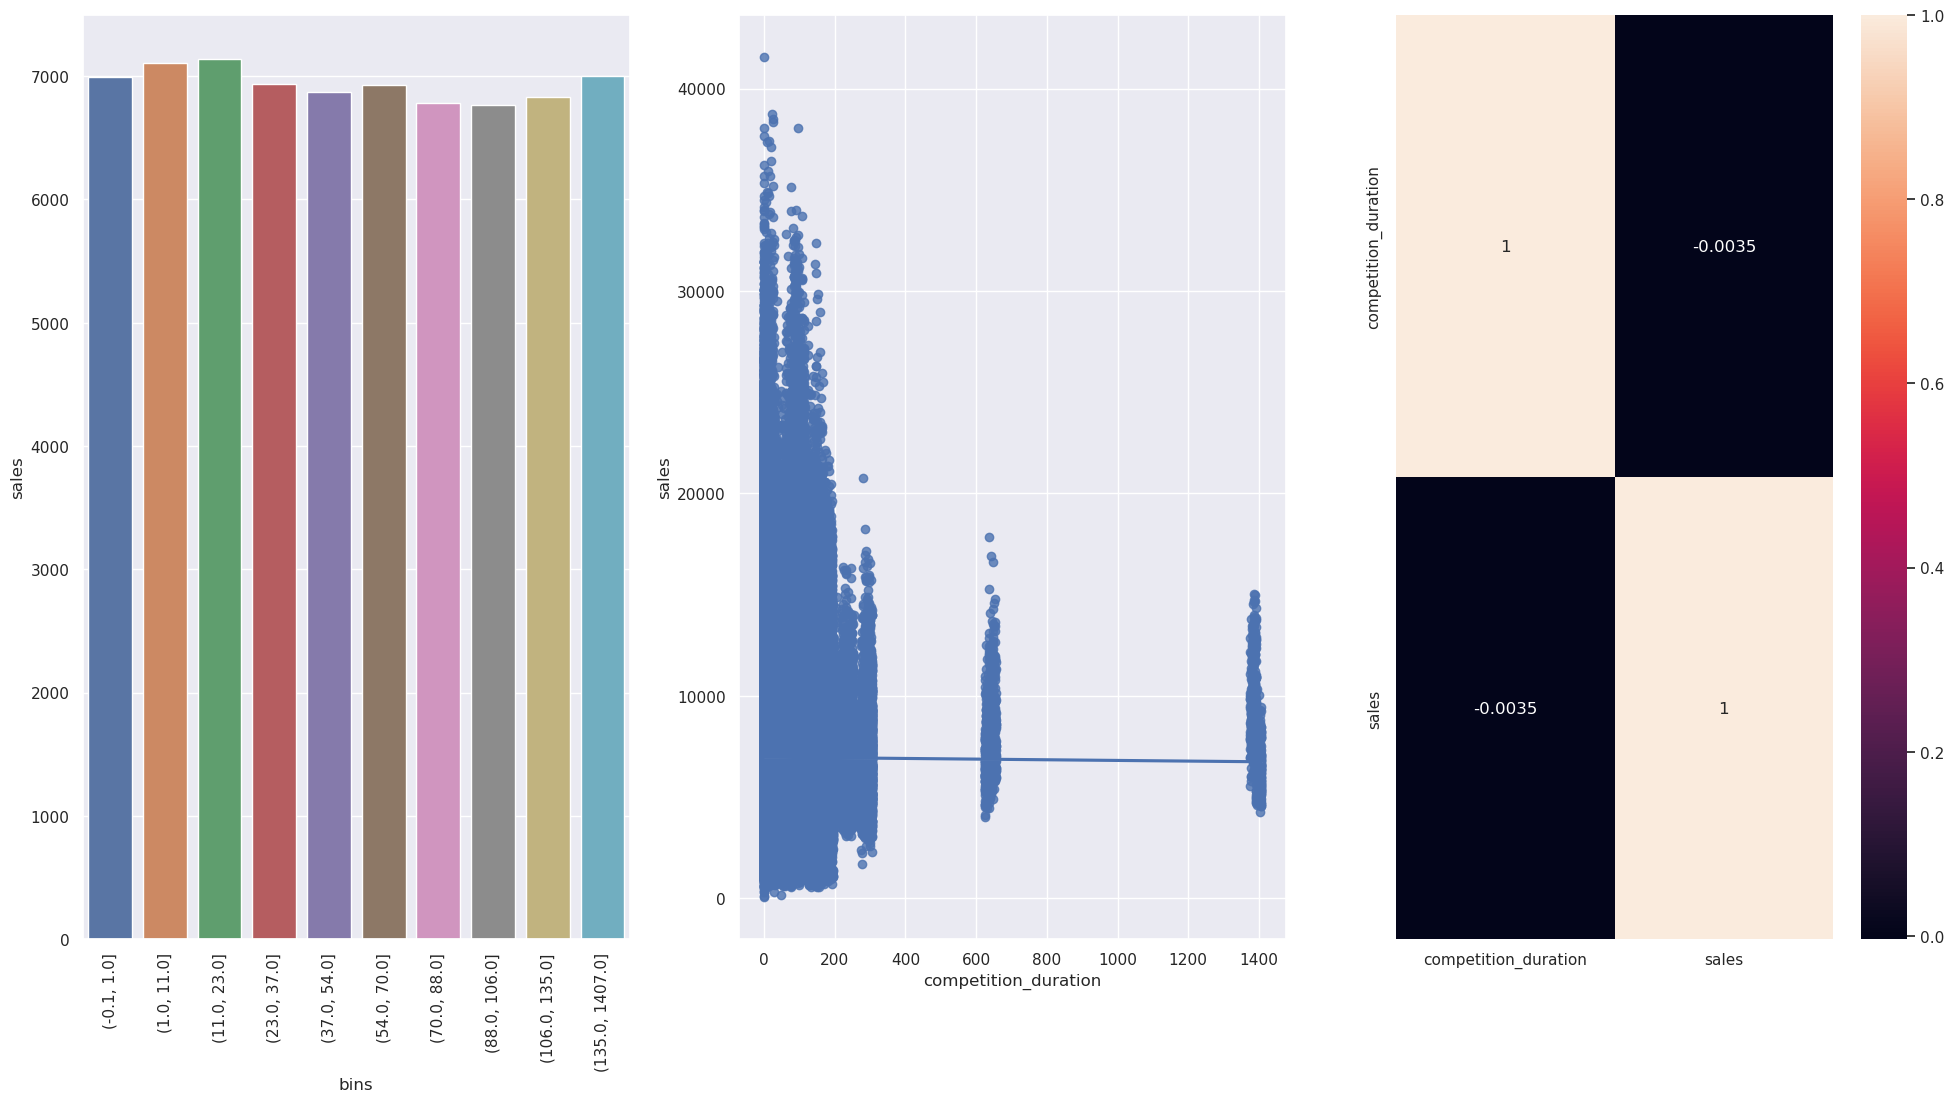

In [34]:
fig, ax = plt.subplots(1, 3)

sns.barplot(data=df_h3_1, x='bins', y='sales', ax=ax[0])
ax[0].set_xticklabels(df_h3_1.bins, rotation=90)

sns.regplot(data=df_h3, x='competition_duration', y='sales', ci=False, ax=ax[1])

ax[2] = plot_2_var_corr(df4, 'competition_duration', 'sales')

plt.show()

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

In [35]:
df_h4 = df4.loc[(df4['is_promo'] == True), ['promo_time_week', 'sales']]
df_h4['bins'] = pd.qcut(df_h4['promo_time_week'], 15, precision=1)

df_h4_1 = df_h4.groupby('promo_time_week').agg({'sales': 'median'}).reset_index()
df_h4_2 = df_h4.groupby('bins').agg({'sales': 'median'}).reset_index()

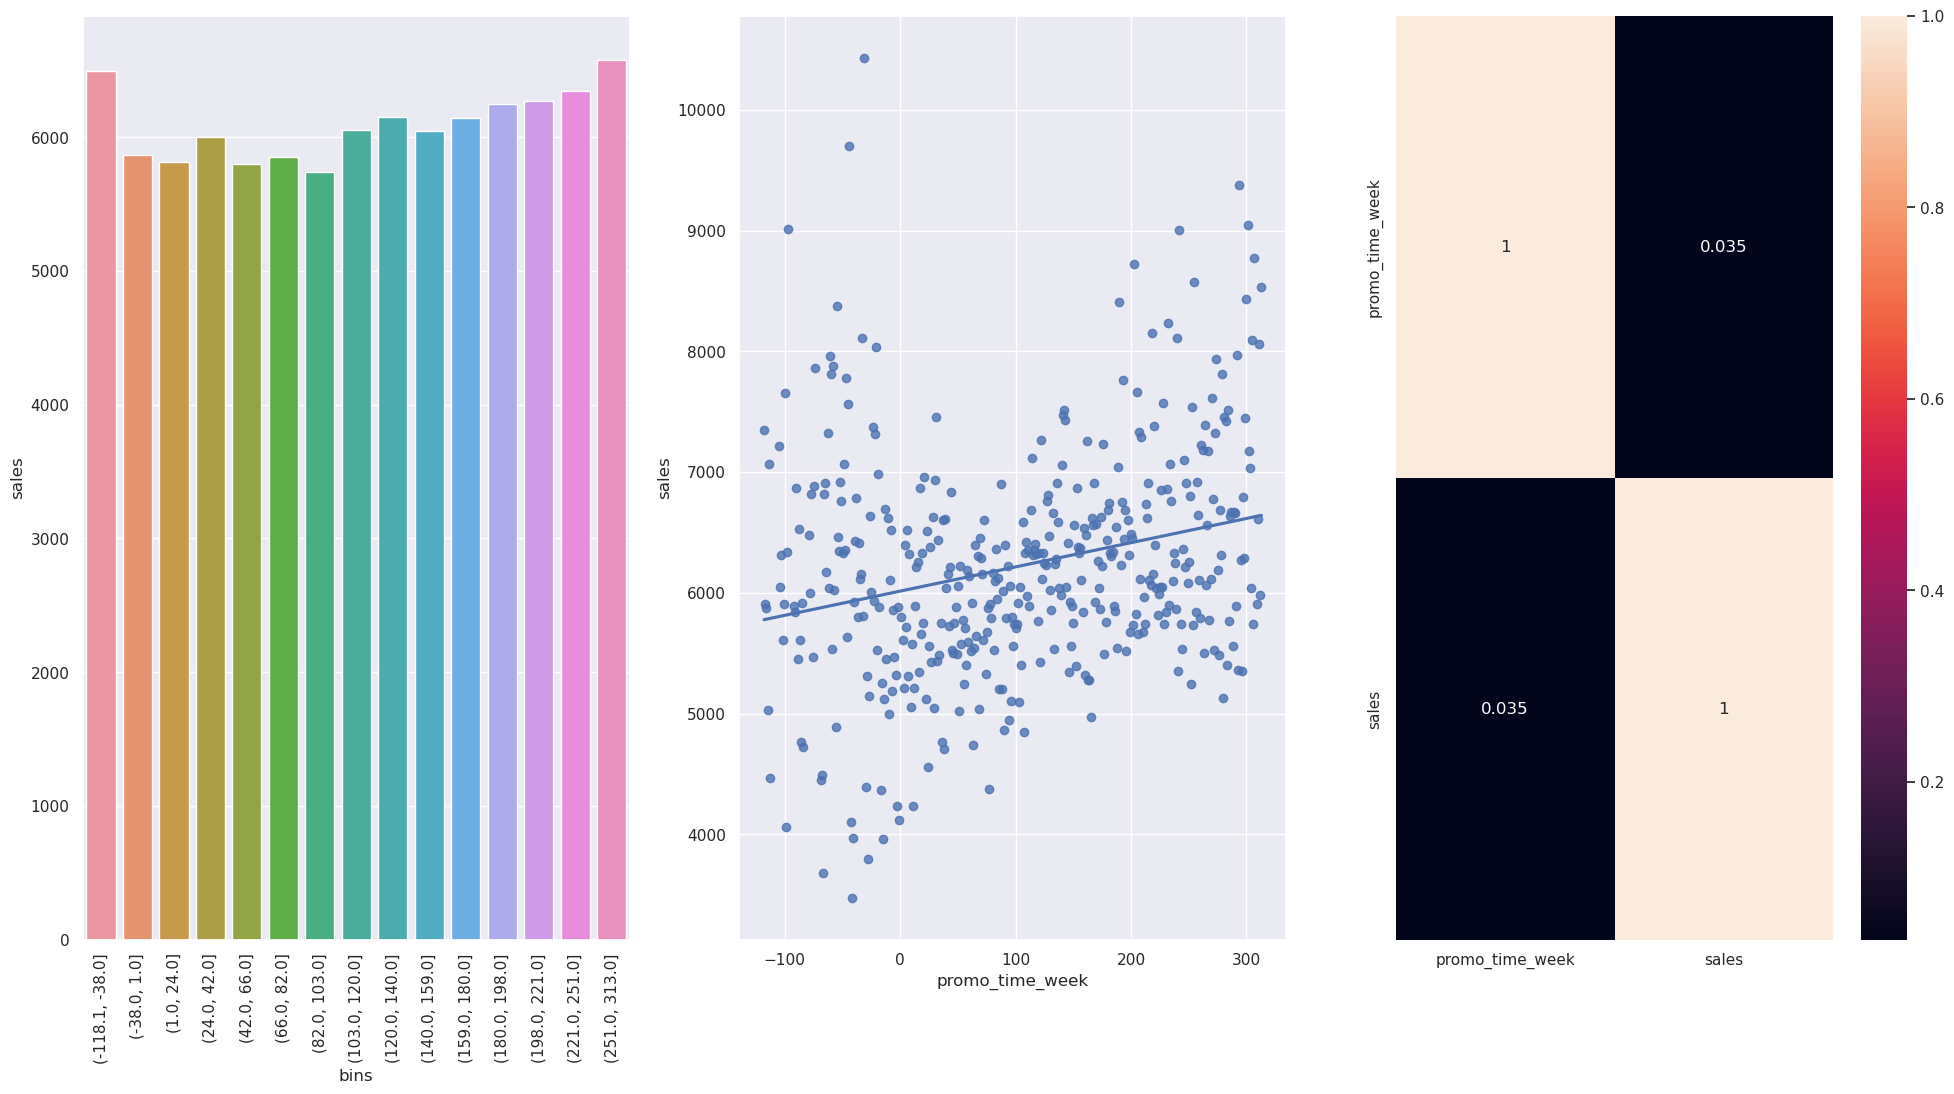

In [36]:
fig, ax = plt.subplots(1, 3)

sns.barplot(data=df_h4_2, x='bins', y='sales', ax=ax[0])
ax[0].set_xticklabels(df_h4_2['bins'], rotation=90)

sns.regplot(data=df_h4_1, x='promo_time_week', y='sales', ci=False, ax=ax[1]);

ax[2] = plot_2_var_corr(df4[df4['is_promo'] == True], 'promo_time_week', 'sales')

plt.show()

#### H5. Lojas com mais dias de promoção deveriam vender mais.

In [37]:
df_h5 = df4.loc[df4['promo'] == True].groupby(['store']).agg({'promo': 'sum', 'sales': 'mean'})
df_h5_2 = df_h5.groupby('promo').sales.mean().reset_index()

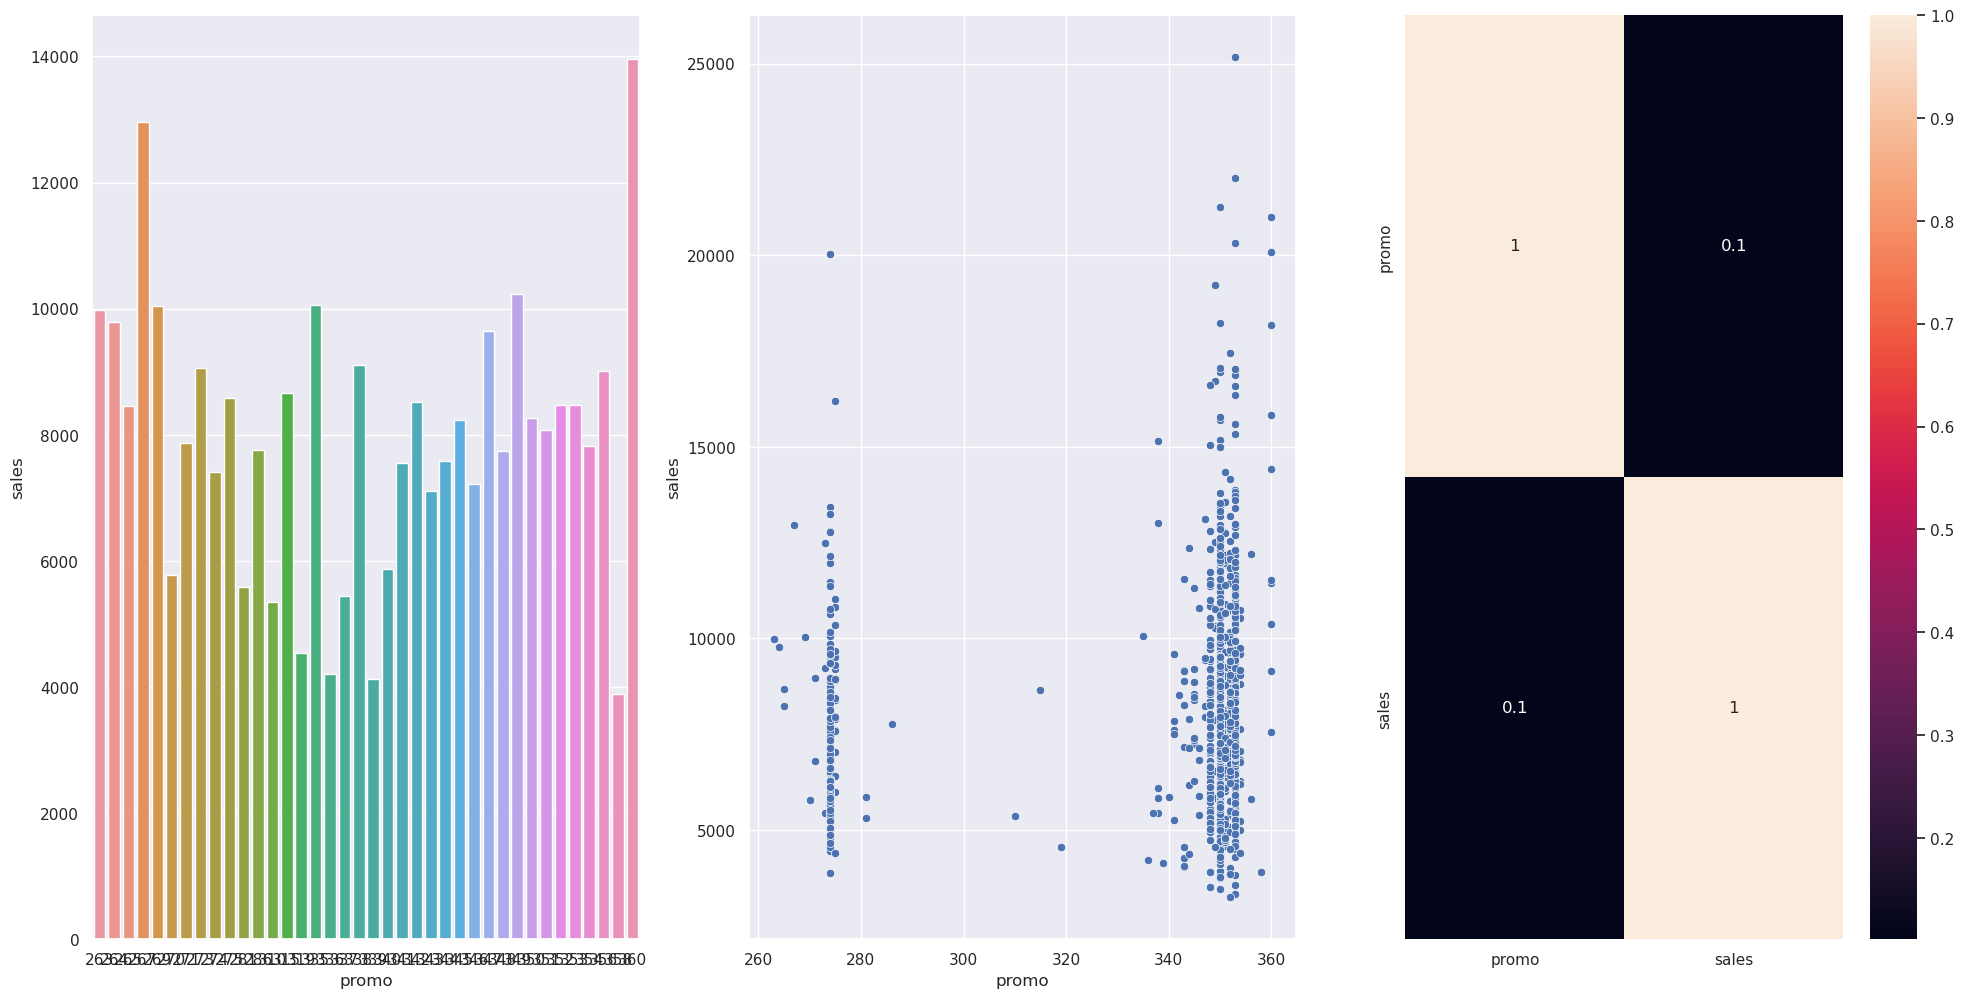

In [38]:
fig, ax = plt.subplots(1, 3)

sns.barplot(data=df_h5_2, x='promo', y='sales', ax=ax[0])

sns.scatterplot(data=df_h5, x='promo', y='sales', ax=ax[1])

ax[2] = plot_2_var_corr(df_h5, 'promo', 'sales')

plt.show()

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.

In [39]:
df_h6_1 = df4.query("promo == True & promo2 == True").groupby('year_week').agg({'sales': 'mean'})
df_h6_2 = df4.query("promo == True & promo2 == False").groupby('year_week').agg({'sales': 'mean'})

In [40]:
df4.promo2.value_counts()

0    423292
1    421046
Name: promo2, dtype: int64

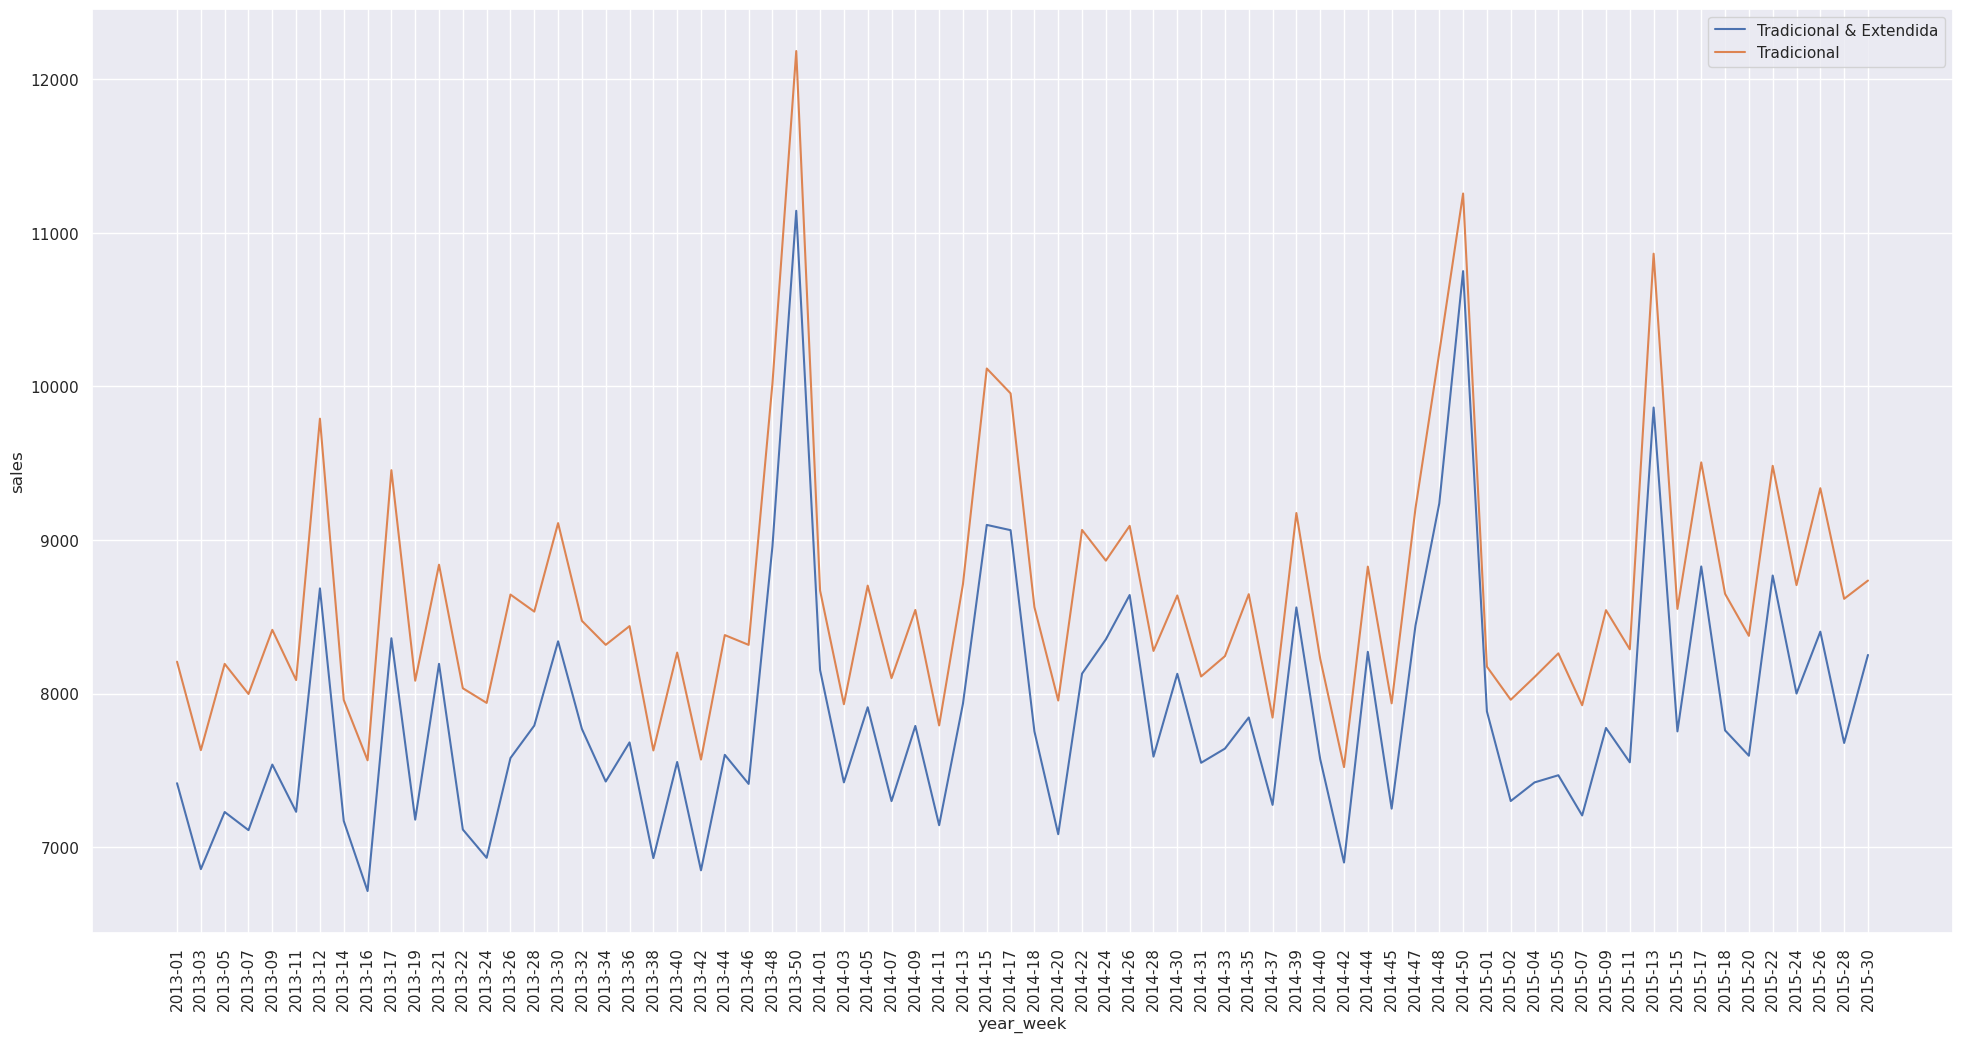

In [41]:
fig, ax = plt.subplots()

sns.lineplot(data=df_h6_1, x='year_week', y='sales', label='Tradicional & Extendida', ax=ax)
sns.lineplot(data=df_h6_2, x='year_week', y='sales', label='Tradicional', ax=ax)
plt.xticks(rotation=90)

plt.legend()
plt.show()

In [42]:
df4.loc[(df4['promo'] == True) & (df4['promo2'] == True)].shape

(187870, 25)

#### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

In [43]:
df_h7 = df4.query("state_holiday != 'regular_day'").groupby('state_holiday').agg({'sales': 'sum'}).reset_index()
df_h7_2 = df4.query("state_holiday != 'regular_day'").groupby(['year', 'state_holiday']).agg({'sales': 'sum'}).reset_index()

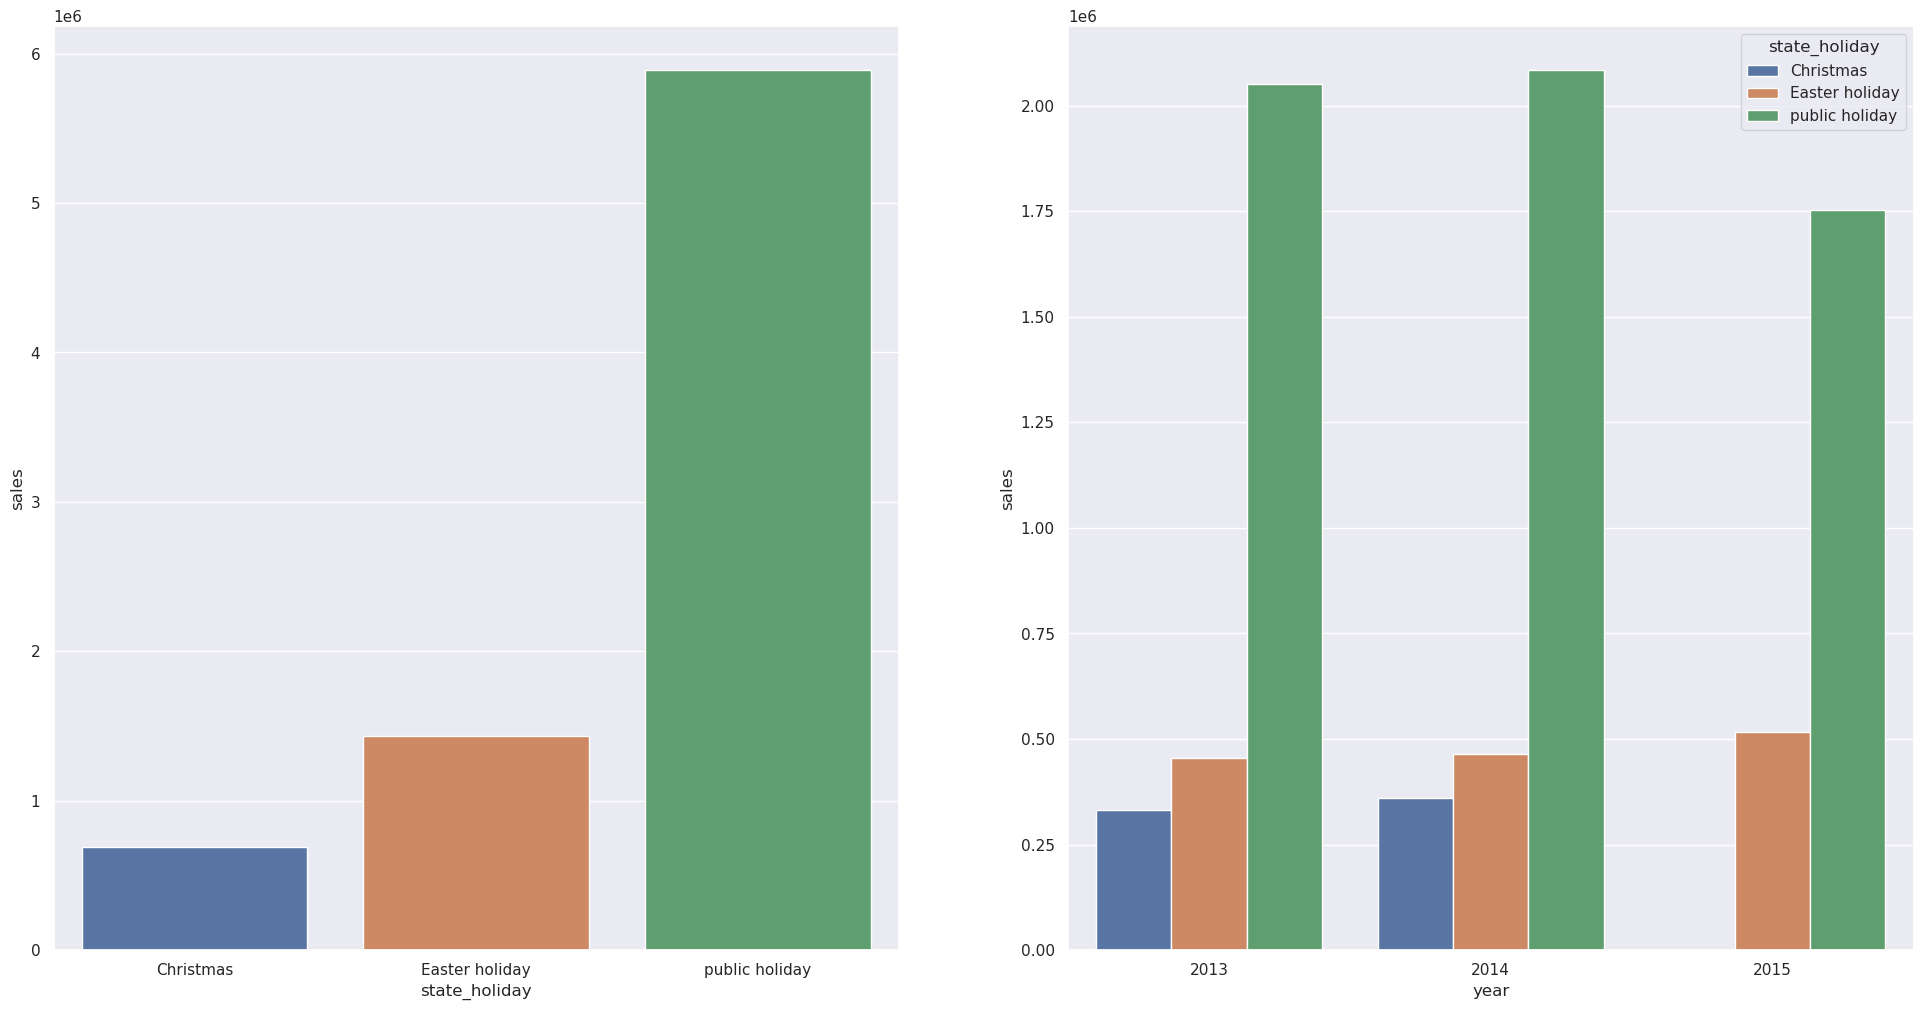

In [44]:
fig, ax = plt.subplots(1, 2)

sns.barplot(data=df_h7, x='state_holiday', y='sales', ax=ax[0])

sns.barplot(data=df_h7_2, x='year', y='sales', hue='state_holiday', ax=ax[1])

plt.show()

#### H8. Lojas deveriam vender mais ao longo dos anos.

In [45]:
df_h8 = df4.groupby(['year']).sales.mean().reset_index()
df_h8_2 = df4.groupby(['year']).sales.sum().reset_index()

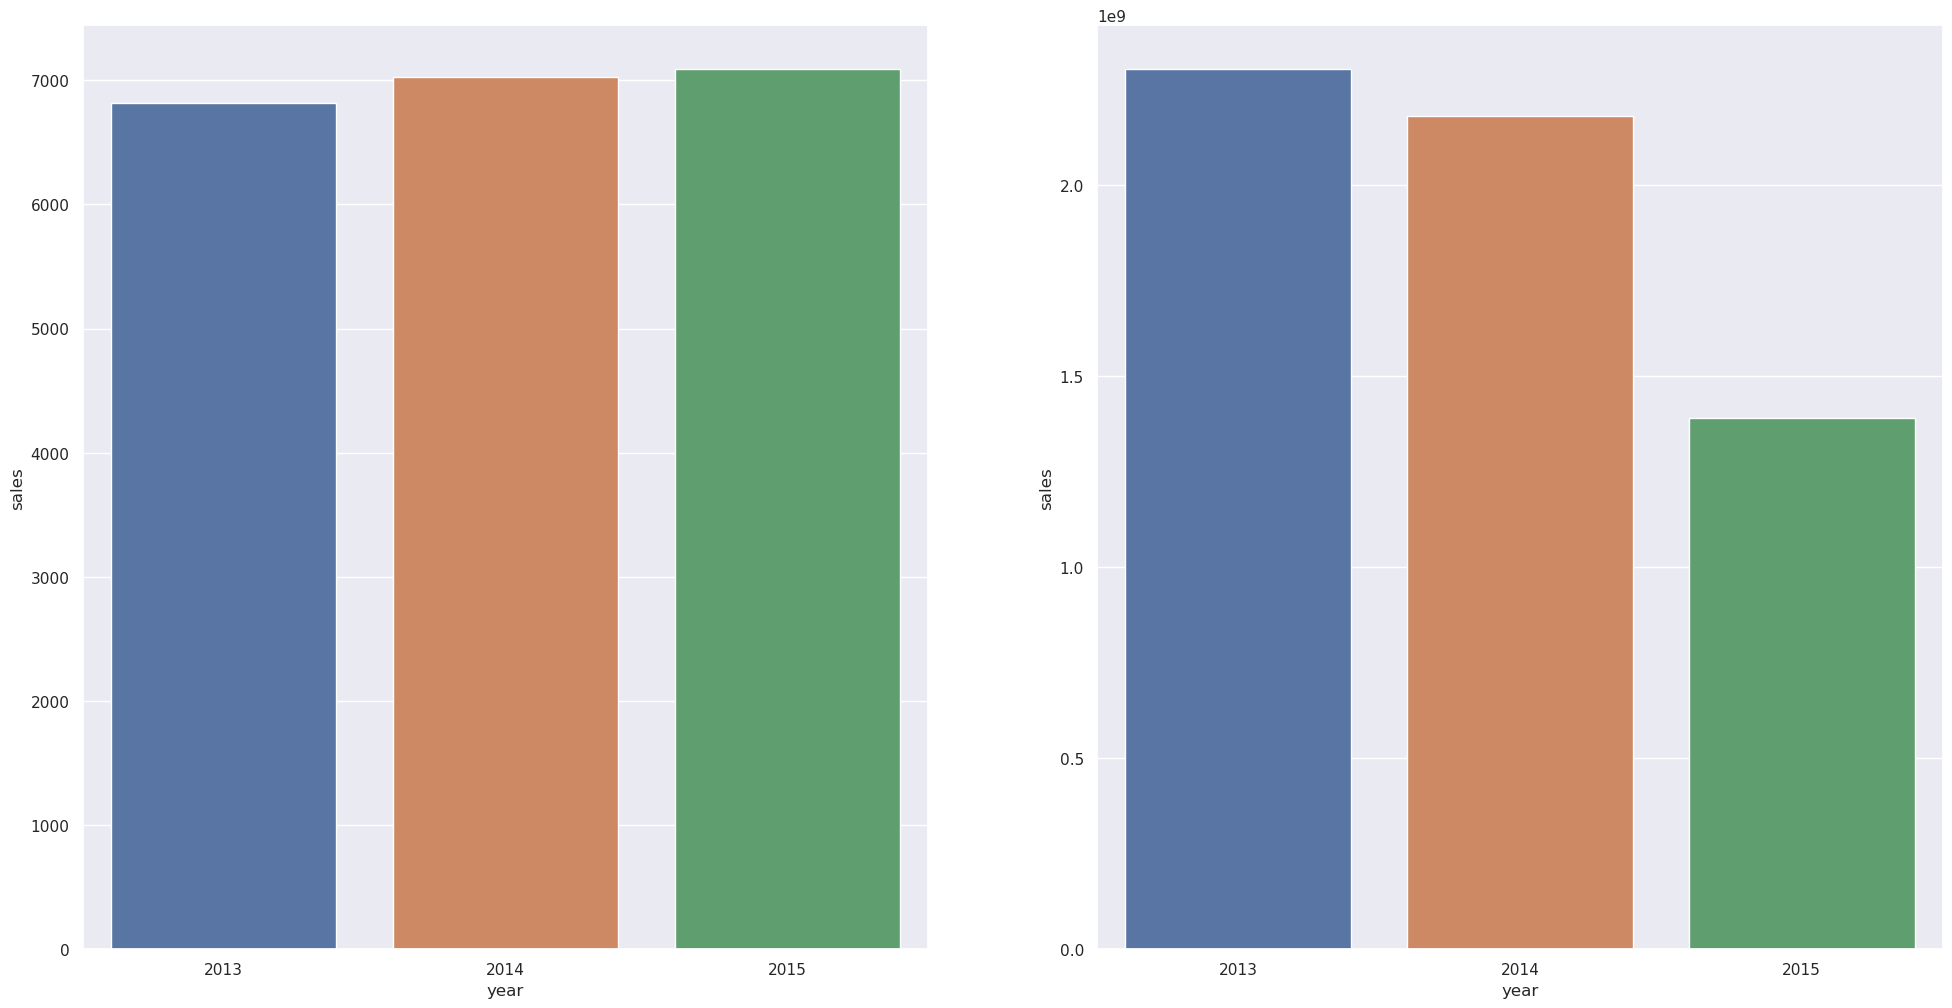

In [46]:
fig, ax = plt.subplots(1, 2)

sns.barplot(data=df_h8, x='year', y='sales', ax=ax[0])
sns.barplot(data=df_h8_2, x='year', y='sales', ax=ax[1])

plt.show()

#### H9. Lojas deveriam vender mais no segundo semestre do ano.

In [47]:
df_h9 = df4.loc[:, ['month', 'sales']]
df_h9['semester'] = ((df4['month'] - 1) // 6) + 1
df_h9_1 = df_h9.groupby('semester').sales.mean().reset_index()

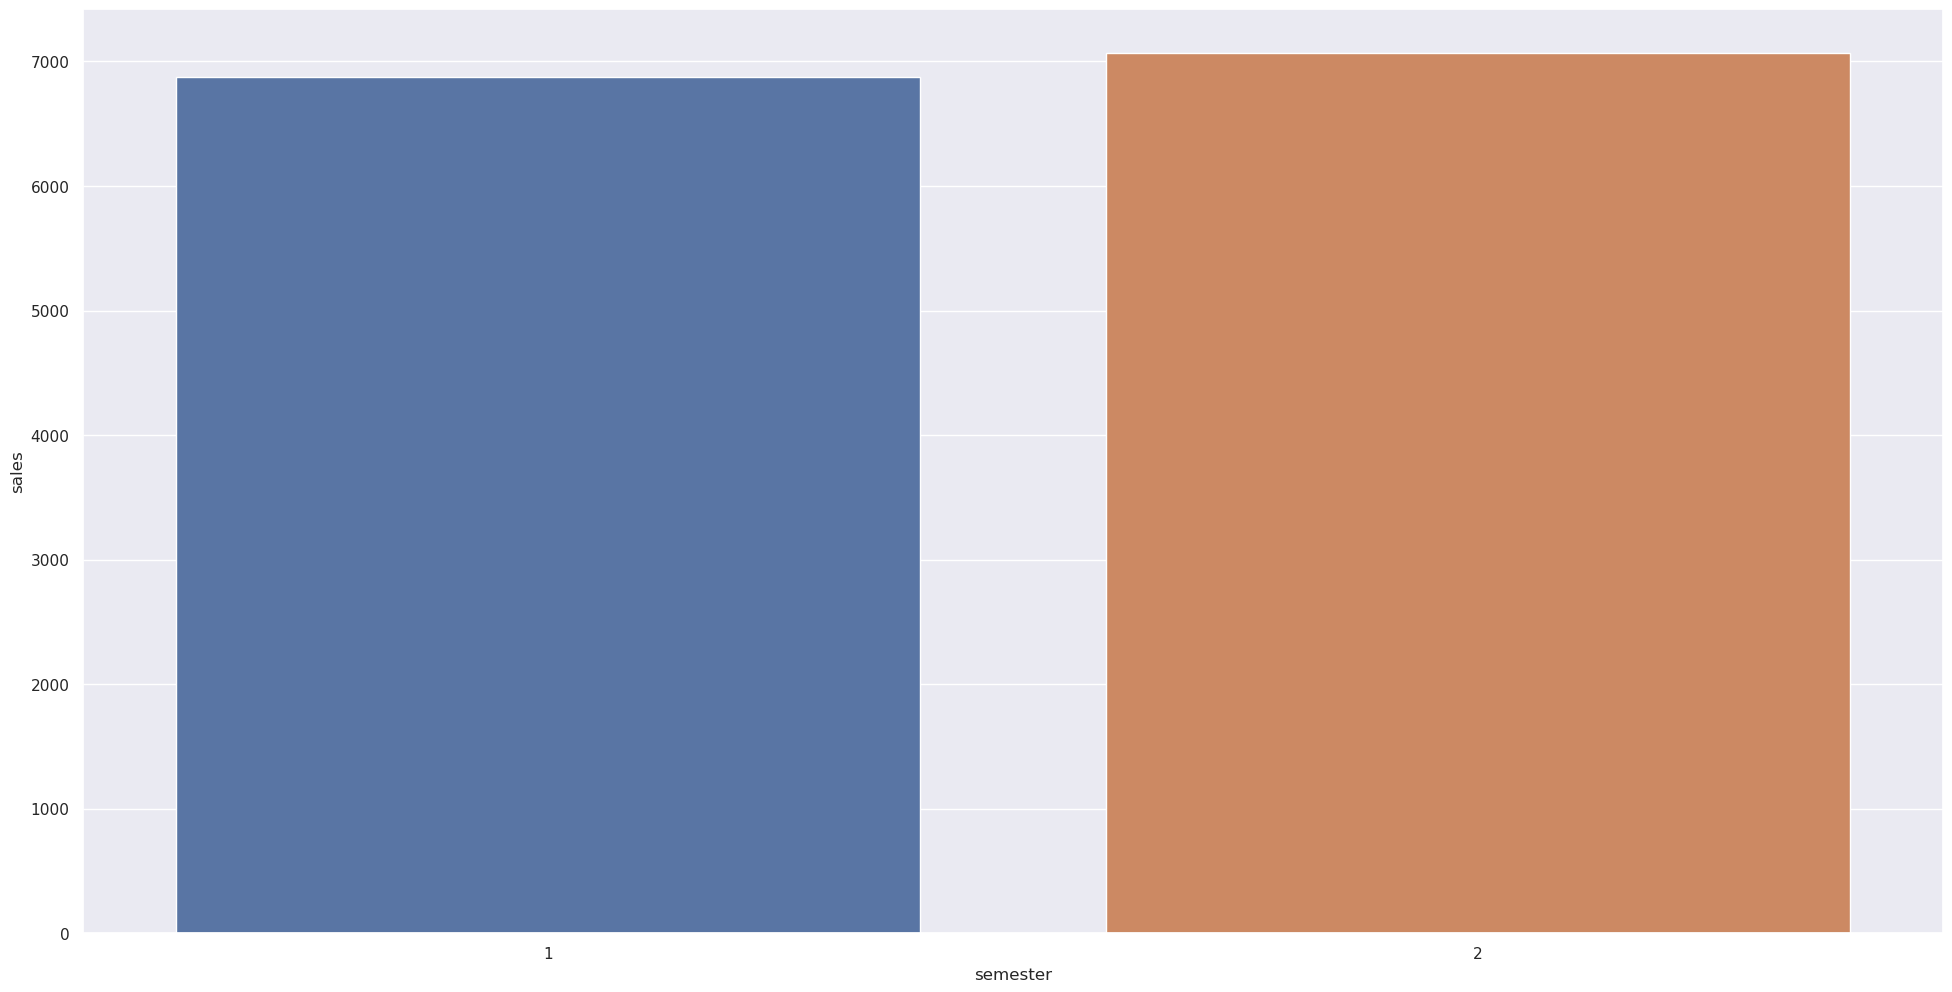

In [48]:
fig, ax = plt.subplots()

sns.barplot(data=df_h9_1, x='semester', y='sales')

plt.show()

In [49]:
df4[df4['year'] == 2015].month.unique()

array([7, 6, 5, 4, 3, 2, 1])

#### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

In [50]:
df_h10 = df4.loc[:, ['day', 'sales']].groupby('day').sales.mean().reset_index()
df_h10 = df_h10.groupby(df_h10['day'] > 10).sales.mean().reset_index()

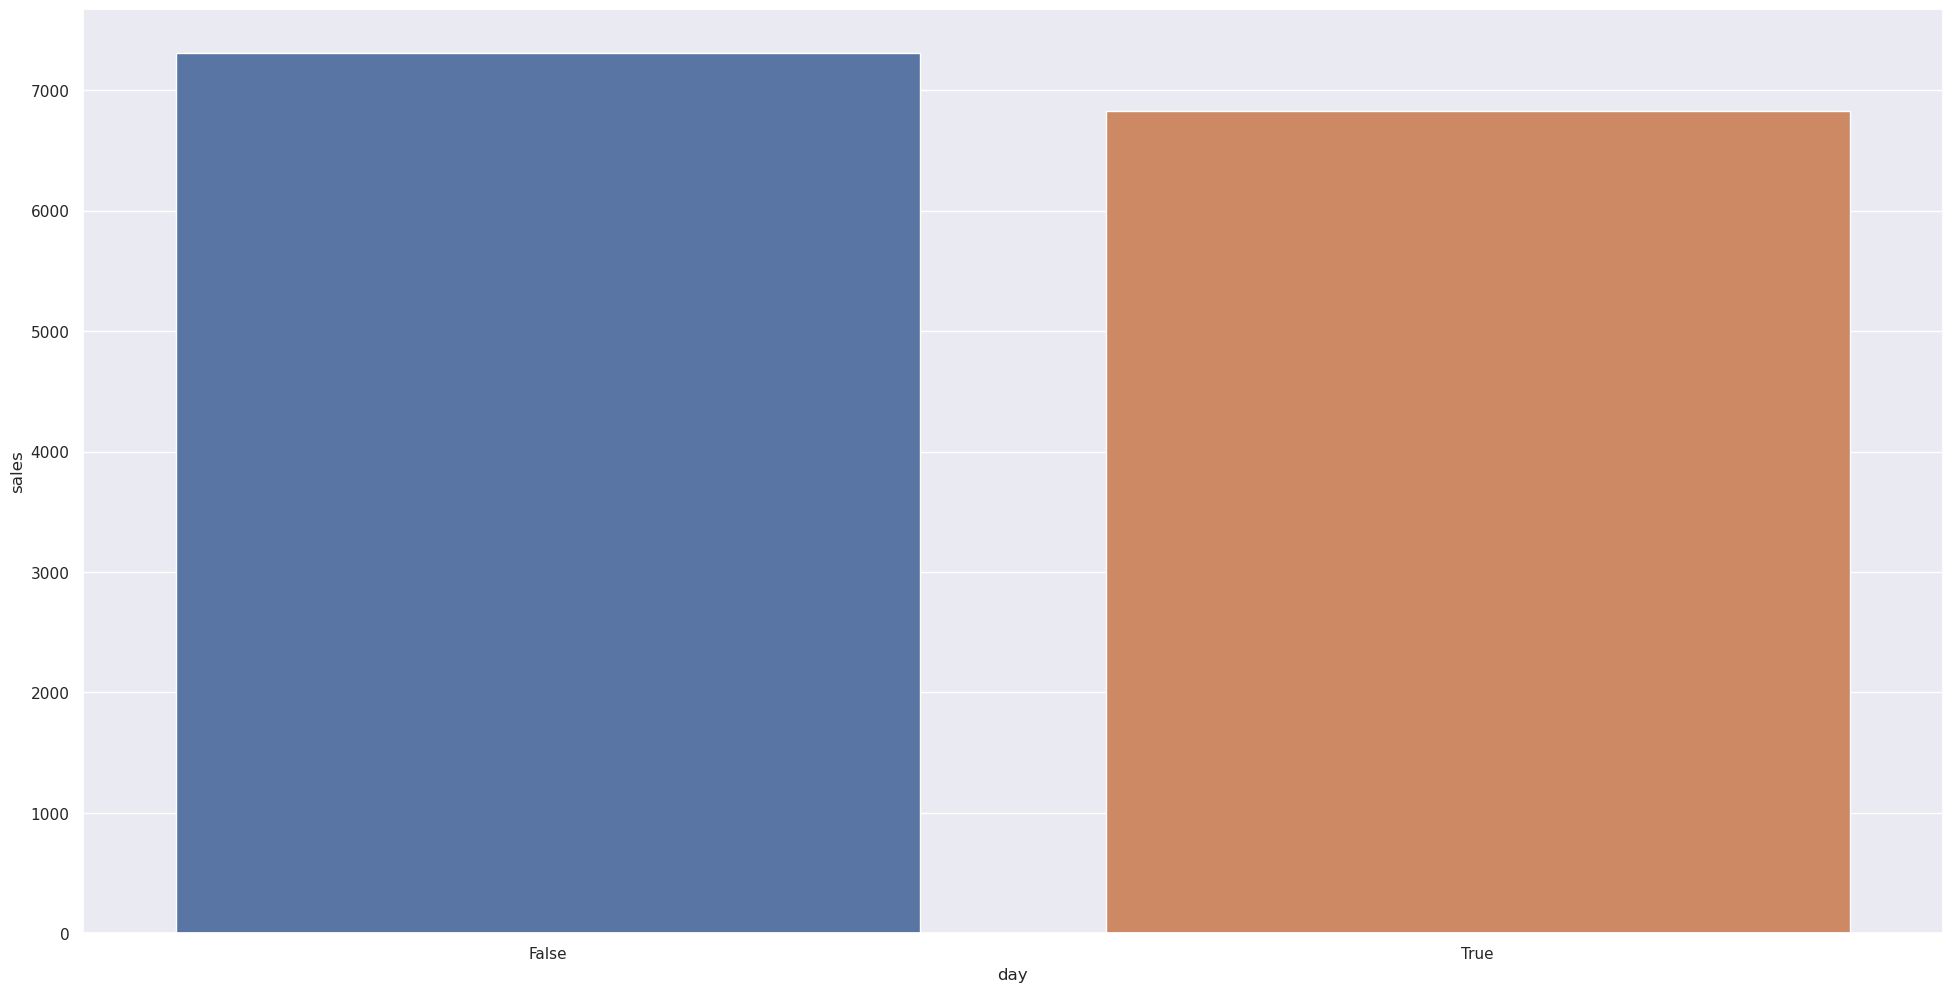

In [51]:
fig, ax = plt.subplots()

sns.barplot(data=df_h10, x='day', y='sales')

plt.show()

#### H11. Lojas deveriam vender menos aos finais de semana.

In [52]:
df_h11 = df4.loc[:, ['day_of_week', 'sales']].groupby('day_of_week').sales.mean().reset_index()
df_h11 = df_h11.groupby(df_h11['day_of_week'] > 5).sales.mean().reset_index()

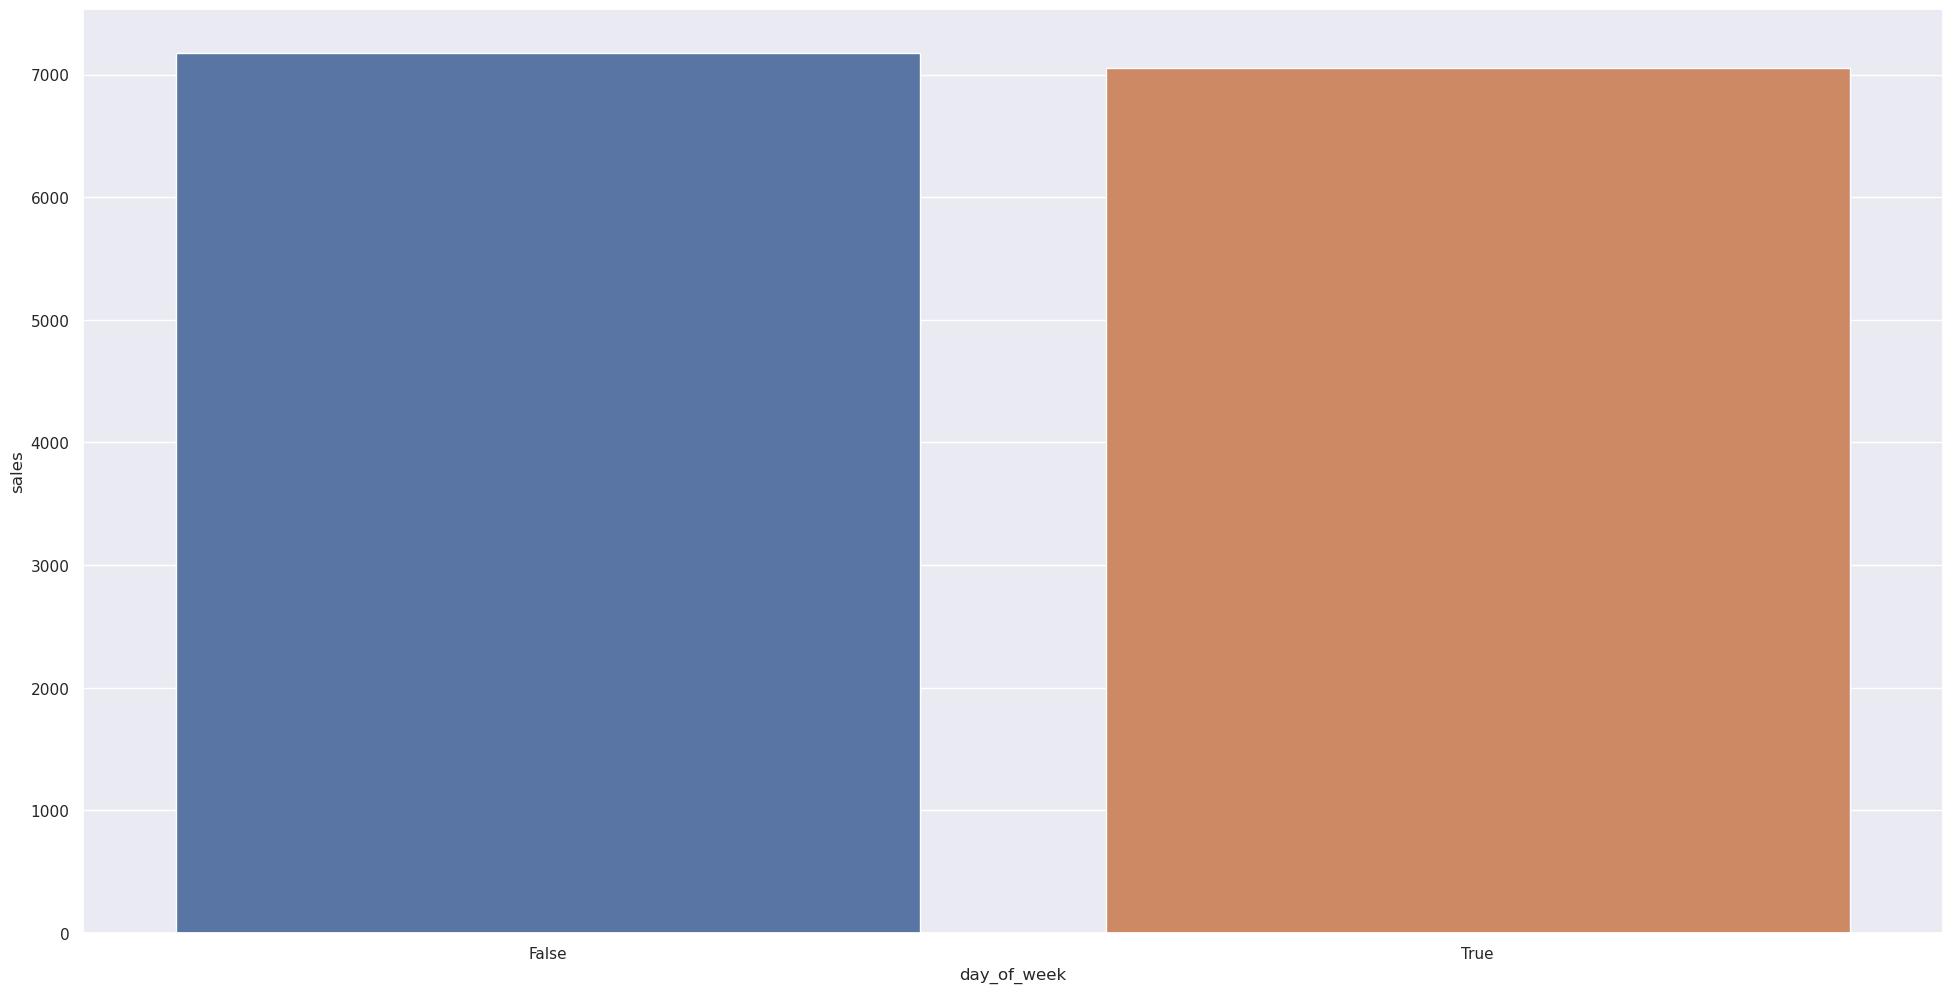

In [53]:
fig, ax = plt.subplots()

sns.barplot(data=df_h11, x='day_of_week', y='sales')

plt.show()

#### H12. Lojas deveriam vender menos durante os feriados escolares.

In [54]:
df_h12 = df4.groupby('school_holiday').sales.mean().reset_index()

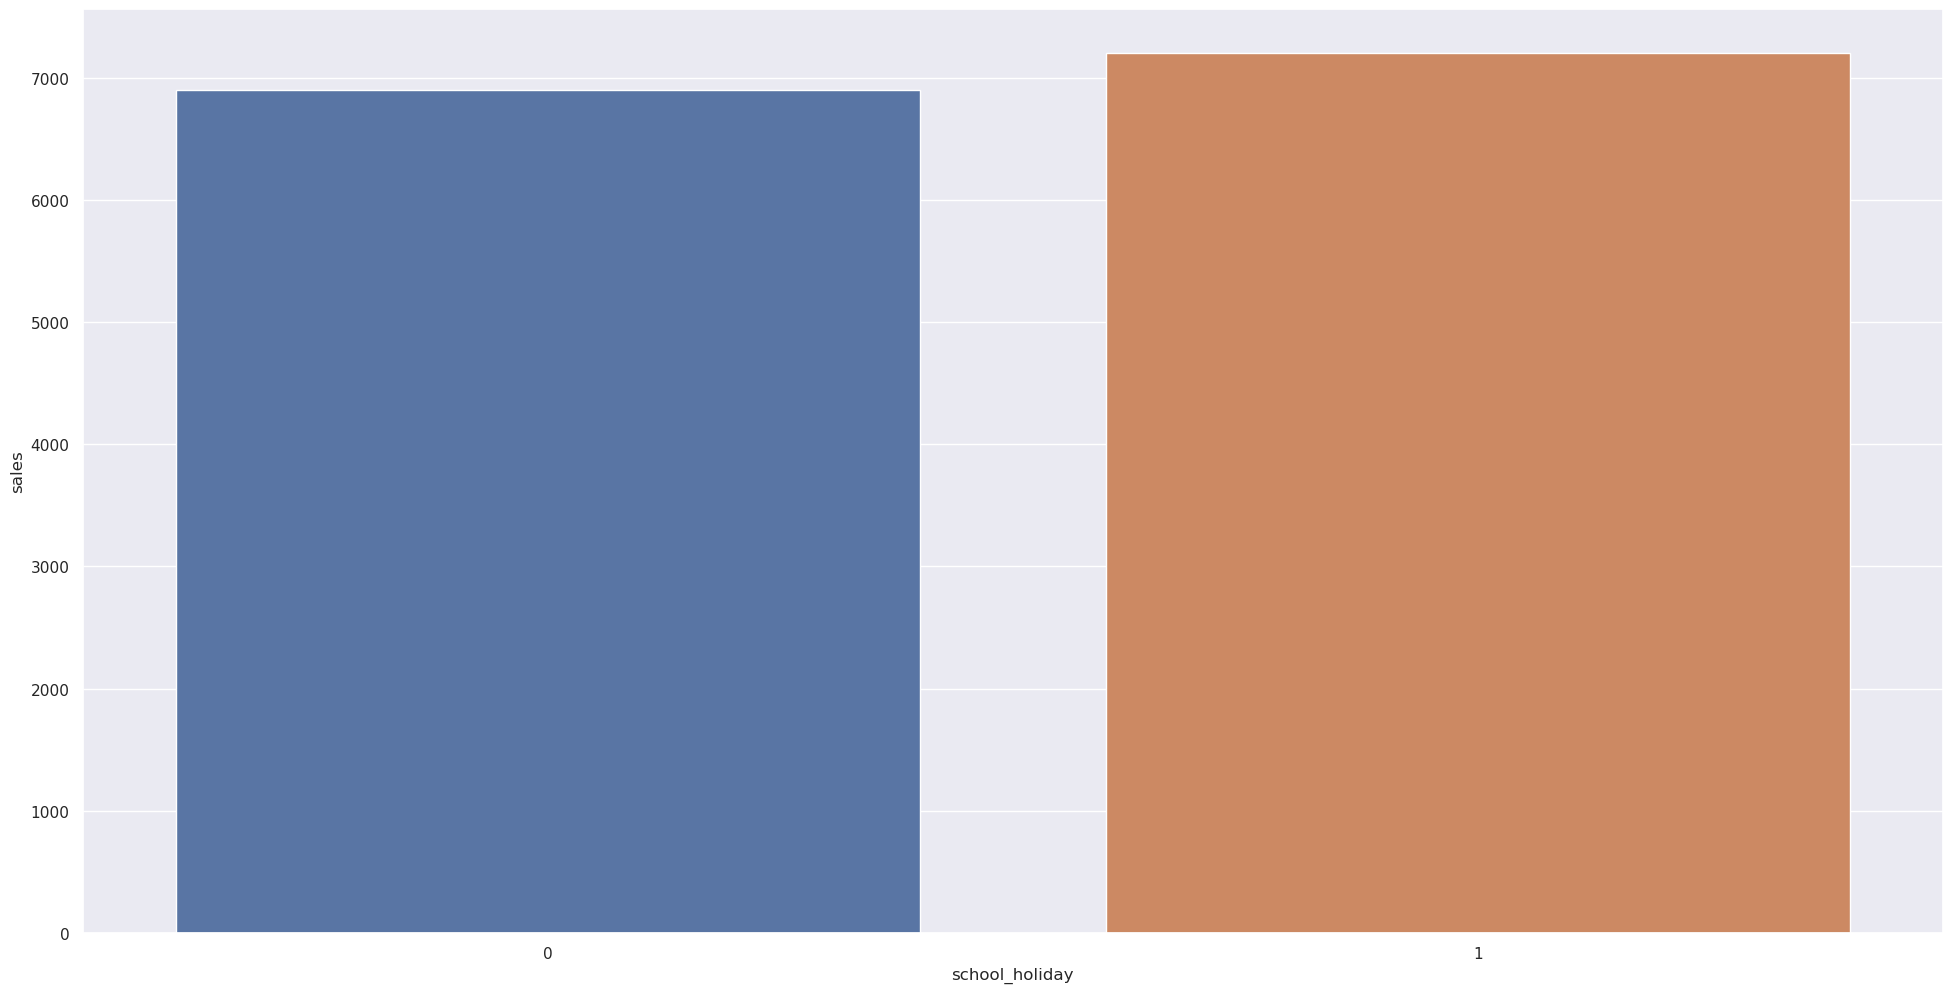

In [55]:
fig, ax = plt.subplots()

sns.barplot(data=df_h12, x='school_holiday', y='sales')

plt.show()

### 4.3) Análise Multivariada

#### 4.3.1) Variáveis Numéricas

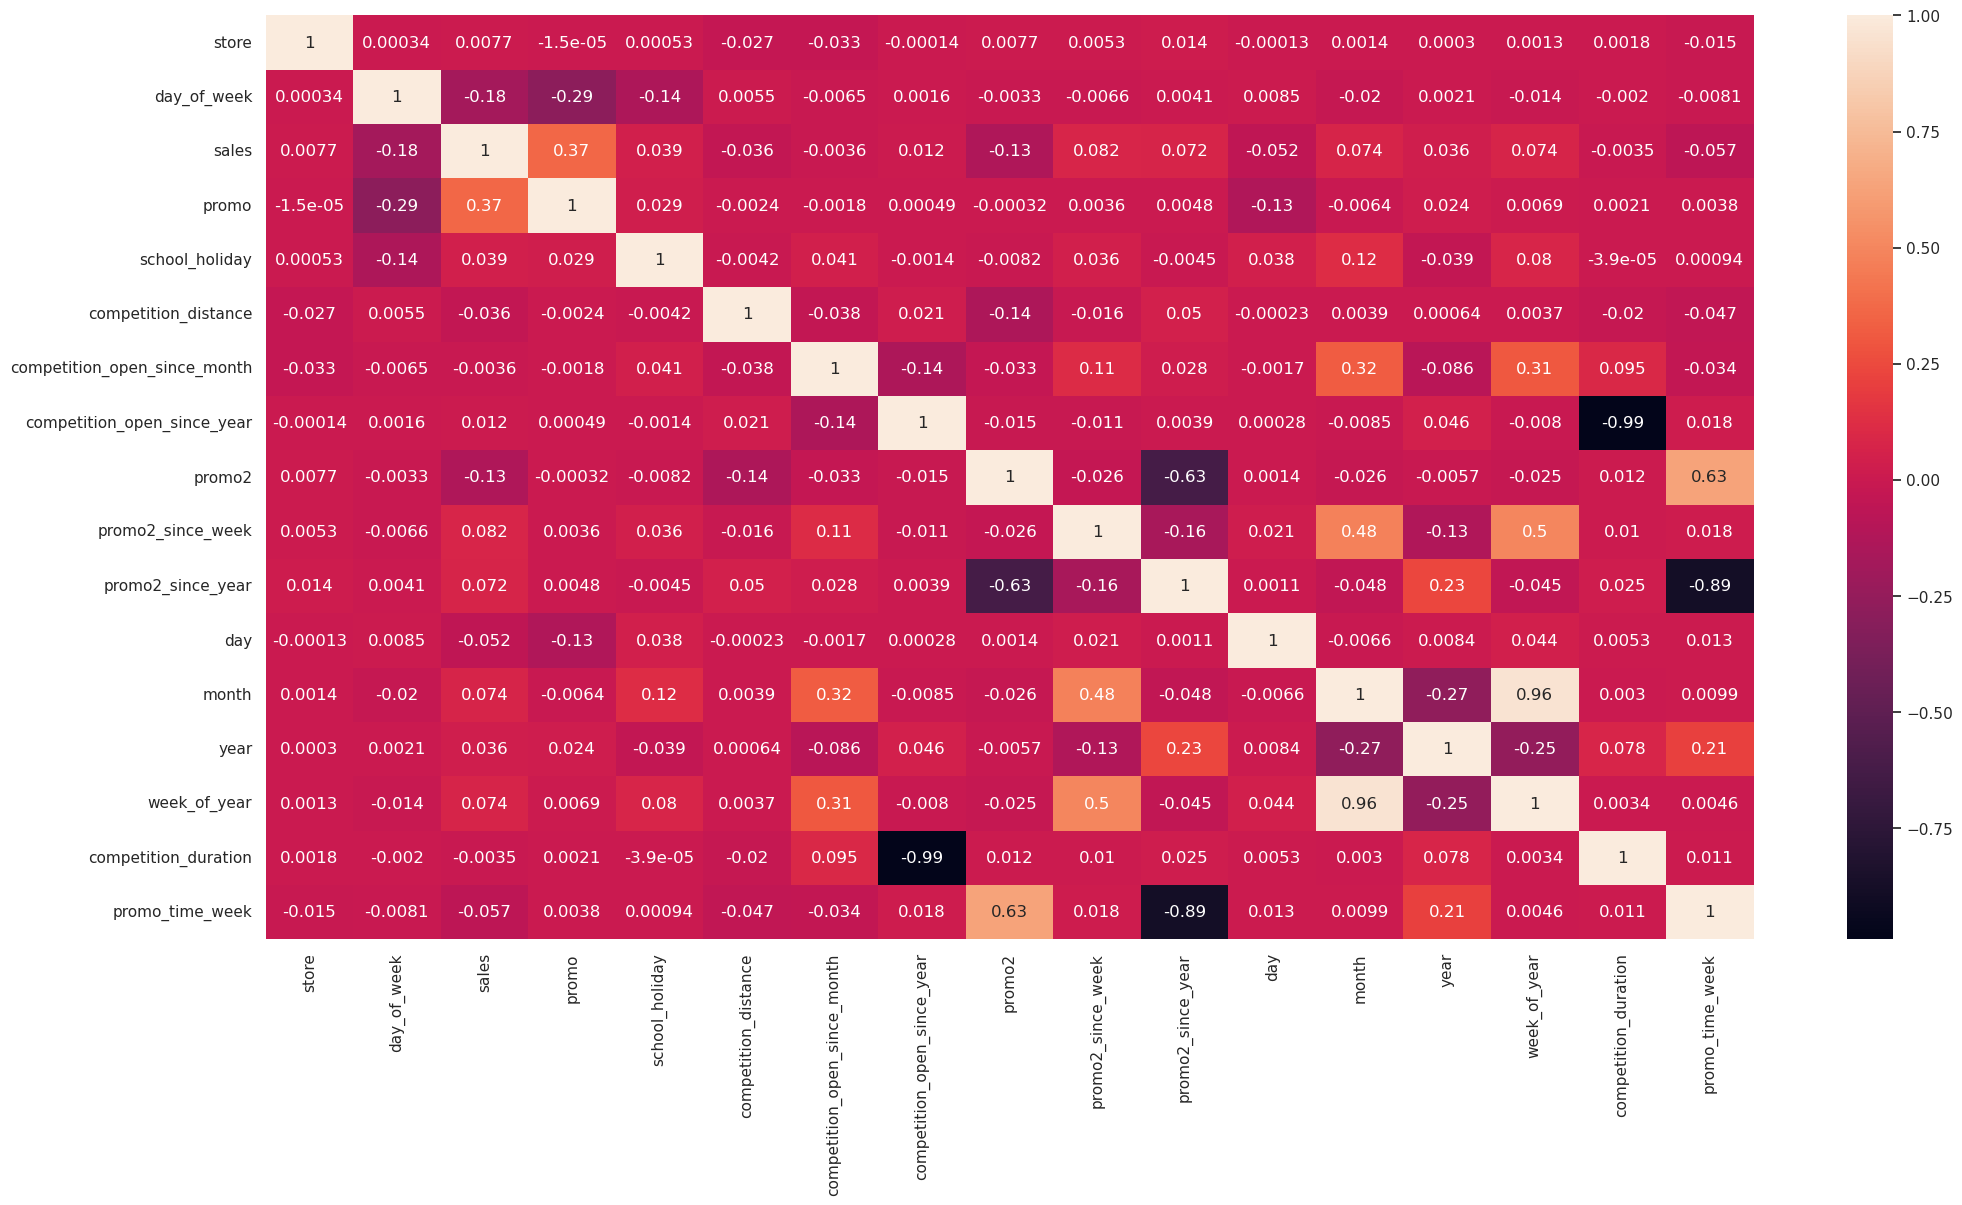

In [56]:
correlation = df4.select_dtypes(include=[int, float, 'datetime64[ns]']).corr( method='pearson' )
sns.heatmap( correlation, annot=True );

#### 4.3.2) Variáveis Categóricas

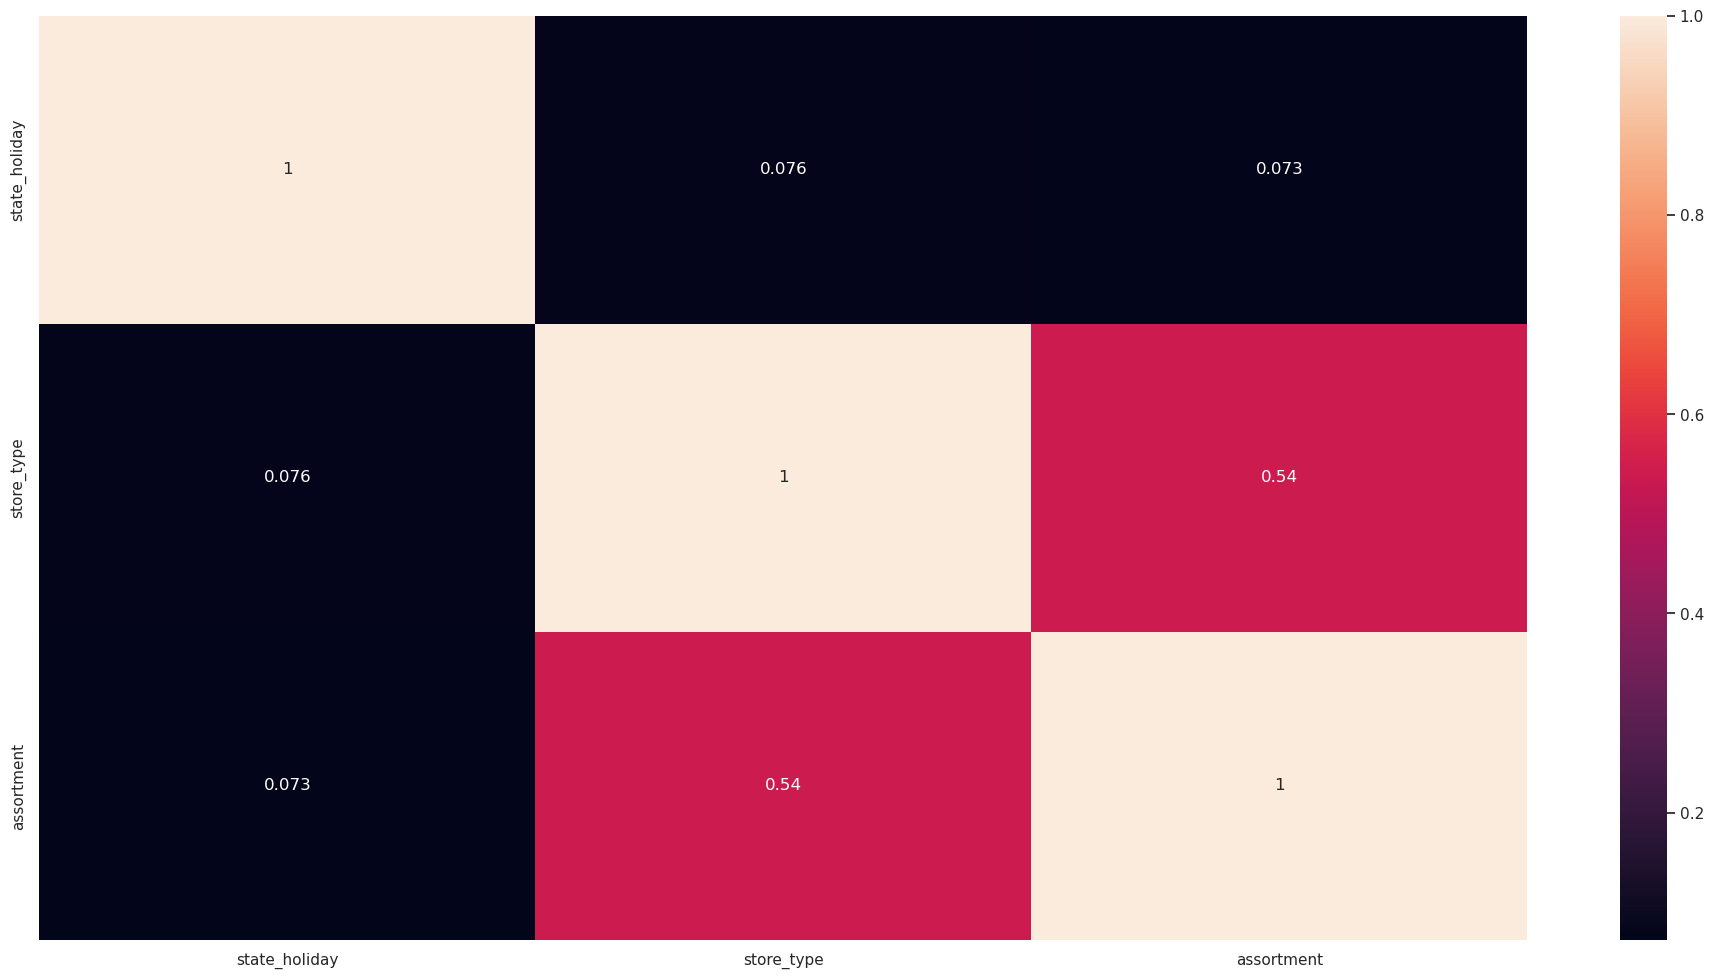

In [57]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# 5.0) Preparação dos Dados

In [58]:
df5 = df4.copy()

### 5.1) Normalização

In [59]:
# Não há variáveis independentes com a distribuição normal

### 5.2) Rescaling

In [60]:
mms = MinMaxScaler()
rs = RobustScaler()

# competition_distance -> RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition_open_since -> RobustScaler
df5['competition_open_since'] = rs.fit_transform(df5[['competition_open_since']].values)
pickle.dump(rs, open('parameter/competition_open_since_scaler.pkl', 'wb'))

# competition_duration -> RobustScaler
df5['competition_duration'] = rs.fit_transform(df5[['competition_duration']].values)
pickle.dump(rs, open('parameter/competition_duration_scaler.pkl', 'wb'))

# promo2_since -> MinMaxScaler
df5['promo2_since'] = mms.fit_transform(df5[['promo2_since']].values)
pickle.dump(mms, open('parameter/promo2_since_scaler.pkl', 'wb'))

# promo_time_week -> MinMaxScaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# week_of_year -> MinMaxScaler
df5['week_of_year'] = mms.fit_transform(df5[['week_of_year']].values)
pickle.dump(mms, open('parameter/week_of_year_scaler.pkl', 'wb'))

### 5.3) Transformações

#### 5.3.1) Encoding

In [61]:
ohe = OneHotEncoder()
le = LabelEncoder()
oe = OrdinalEncoder()

# promo, school_holiday, promo2, is_promo -> OneHot
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type -> Label *
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_encoder.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

#### 5.3.2) Transformação da variável Target

In [62]:
df5['sales'] = np.log1p(df5['sales'])

#### 5.3.3) Transformação de Natureza

In [63]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6) Seleção de Features

In [64]:
df6 = df5.copy()

In [65]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'competition_open_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

### 6.1) Split dos dados em treino e teste

In [66]:
# dados de treino
X_train = df6.loc[df6['date'] < '2015-06-19', :]
y_train = df6.loc[df6['date'] < '2015-06-19', 'sales']

# dados de teste
X_test = df6.loc[df6['date'] >= '2015-06-19', :]
y_test = df6.loc[df6['date'] >= '2015-06-19', 'sales']

print(f"Train Min Date: {X_train.date.min()}")
print(f"Train Max Date: {X_train.date.max()}")

print(f"\nTest Min Date: {X_test.date.min()}")
print(f"Test Min Date: {X_test.date.max()}")

Train Min Date: 2013-01-01 00:00:00
Train Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


### 6.2) Seleção de features com Boruta

In [67]:
# # train and test dataset for boruta
# x_train_np = X_train.drop(columns=['date', 'sales']).values
# y_train_np = y_train.values.ravl()

# # defining estimator -> RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # running boruta process
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_np, y_train_np)

#### 6.2.1) Melhores features selecionadas pelo Boruta

In [68]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(columns=['date', 'sales'])
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))


### 6.3) Seleção de features manual

In [72]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_duration',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos',
]

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7) Treinamento de algoritmos de ML

In [73]:
df7 = df6.copy()

In [74]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# para o cross-validation
x_training = X_train[cols_selected_boruta_full]

### 7.1) Modelo Baseline

In [75]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
aux2 = aux1.groupby('store').agg({'sales': 'mean'}).rename(columns={'sales': 'predictions'})
aux2 = aux1.merge(aux2, how='left', left_on='store', right_index=True)

baseline_results = ml_error('Average Model', np.expm1(y_test), np.expm1(aux2['predictions']))
baseline_results

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.80,0.21,1835.14


### 7.2) Linear Models

#### 7.2.1) Regressão Linear

In [76]:
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# results
lr_results = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_results

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1870.53,0.29,2669.75


**Cross-Validation**

In [77]:
lr_results_cv = cross_validation(x_training, 'Linear Regerssion - CV', lr, 5, verbose=True)
lr_results_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regerssion - CV,2032.90 +/- 247.14,0.30 +/- 0.01,2885.37 +/- 348.96


#### 7.2.2) Regressão Lasso

In [78]:
lss = Lasso(alpha=10).fit(x_train, y_train)

# prediction
yhat_lss = lss.predict(x_test)

# results
lss_results = ml_error('Lasso Regression', np.expm1(y_test), np.expm1(yhat_lss))
lss_results

,Model Name,MAE,MAPE,RMSE
0,Lasso Regression,2198.58,0.34,3110.51


**Cross-Validation**

In [79]:
lss_results_cv = cross_validation(x_training, 'Lasso Regressionn - CV', lss, 5)
lss_results_cv

,Model Name,MAE,MAPE,RMSE
0,Lasso Regressionn - CV,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55


### 7.3) Random Forest Regressor

In [80]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# results
rf_results = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_results

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,685.94,0.10,1021.96


**Cross-Validation**

In [81]:
# results_rf_cv = cross_validation(x_training, 'Random Forest Regressor - CV', rf, 5)
# results_rf_cv

### 7.4) XGBoost Regressor

In [82]:
# model
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    eta=0.01,
    max_depth=10,
    subsample=0.7, 
    colsample_bytree=0.9
).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# results
xgb_results = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_results

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.30,0.95,7330.58


**Cross-Validation**

In [83]:
# xgb_results_cv = cross_validation(x_training, 5, 'XGBoost Regression - CV', model_xgb, verbose=False)
# xgb_results_cv

### 7.5) Compare Models Performance

#### 7.6.1) Single Performance

In [84]:
modelling_result = pd.concat( [baseline_results, lr_results, lss_results, rf_results, xgb_results] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,685.94,0.10,1021.96
0,Average Model,1354.80,0.21,1835.14
0,Linear Regression,1870.53,0.29,2669.75
0,Lasso Regression,2198.58,0.34,3110.51
0,XGBoost Regressor,6683.30,0.95,7330.58


#### 7.6.2) Real Performance - Cross Validation

In [85]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv = pd.concat( [lr_results_cv, lss_results_cv] )
modelling_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regerssion - CV,2032.90 +/- 247.14,0.30 +/- 0.01,2885.37 +/- 348.96
0,Lasso Regressionn - CV,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55


# 8.0) Hyper-parameter Fine Tuning

In [86]:
# df8 = df7.copy()

### 8.1) Random Search

In [87]:
# params = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
# }

# MAX_ITER = 5

In [88]:
# random_search_results = pd.DataFrame()

# for i in range(MAX_ITER):
#     # choose values for parameters randomly
#     cr_params = { k: random.sample(v, 1)[0] for k, v in params.items()}
#     print(cr_params)
    
#     # model
#     model_tuned = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=cr_params['n_estimators'],
#         eta=cr_params['eta'],
#         max_depth=cr_params['max_depth'],
#         subsample=cr_params['subsample'],
#         colsample_bytree=cr_params['colsample_bytree']
#     ).fit(x_train, y_train)
                   
#     # performance
#     result_random_search_cv = cross_validation(x_training, 2, 'XGBoost Regressor', model_tuned, verbose=False)
    
#     random_search_results = pd.concat([random_search_results, result_random_search_cv], axis=0)
                   
# random_search_results

### 8.2) Final Model

In [89]:
# tuned parameters
tuned_params = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

In [90]:
# model
final_model_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=tuned_params['n_estimators'],
    eta=tuned_params['eta'],
    max_depth=tuned_params['max_depth'],
    subsample=tuned_params['subsample'],
    colsample_bytree=tuned_params['colsample_bytree']
).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = final_model_tuned.predict( x_test )

# performance
final_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned))
final_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,765.05,0.12,1098.34


In [91]:
# tendencia do modelo em supervalorizar (valor positivo) ou subvalorizar (valor negativo), em média,
# o valor das previsões.
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.01914051212091045

# 9.0) TRADUCAO E INTERPRETACAO DO ERRO

In [92]:
df9 = X_test[cols_selected_boruta_full]

# rescale back
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### 9.1) Business Performance

In [93]:
df9_1 = df9[['store', 'predictions', 'sales']].groupby('store').agg({'predictions': 'sum', 'sales': 'sum'}).reset_index()

# Errors
df9_1['MAE'] = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions']))
df9_1['MAPE'] = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions']))

# Scenarios
df9_1['worst_scenario'] = df9_1['predictions'] - df9_1['MAE']
df9_1['best_scenario'] = df9_1['predictions'] + df9_1['MAE']

# Order
df9_1 = df9_1[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [94]:
df9_1.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
558,559,216775.78,216446.16,217105.40,329.62,0.10
153,154,322837.19,321830.38,323844.00,1006.81,0.17
156,157,350317.22,349552.97,351081.47,764.25,0.15
211,212,186564.05,184947.14,188180.95,1616.91,0.11
392,393,232725.20,231971.22,233479.19,753.99,0.11


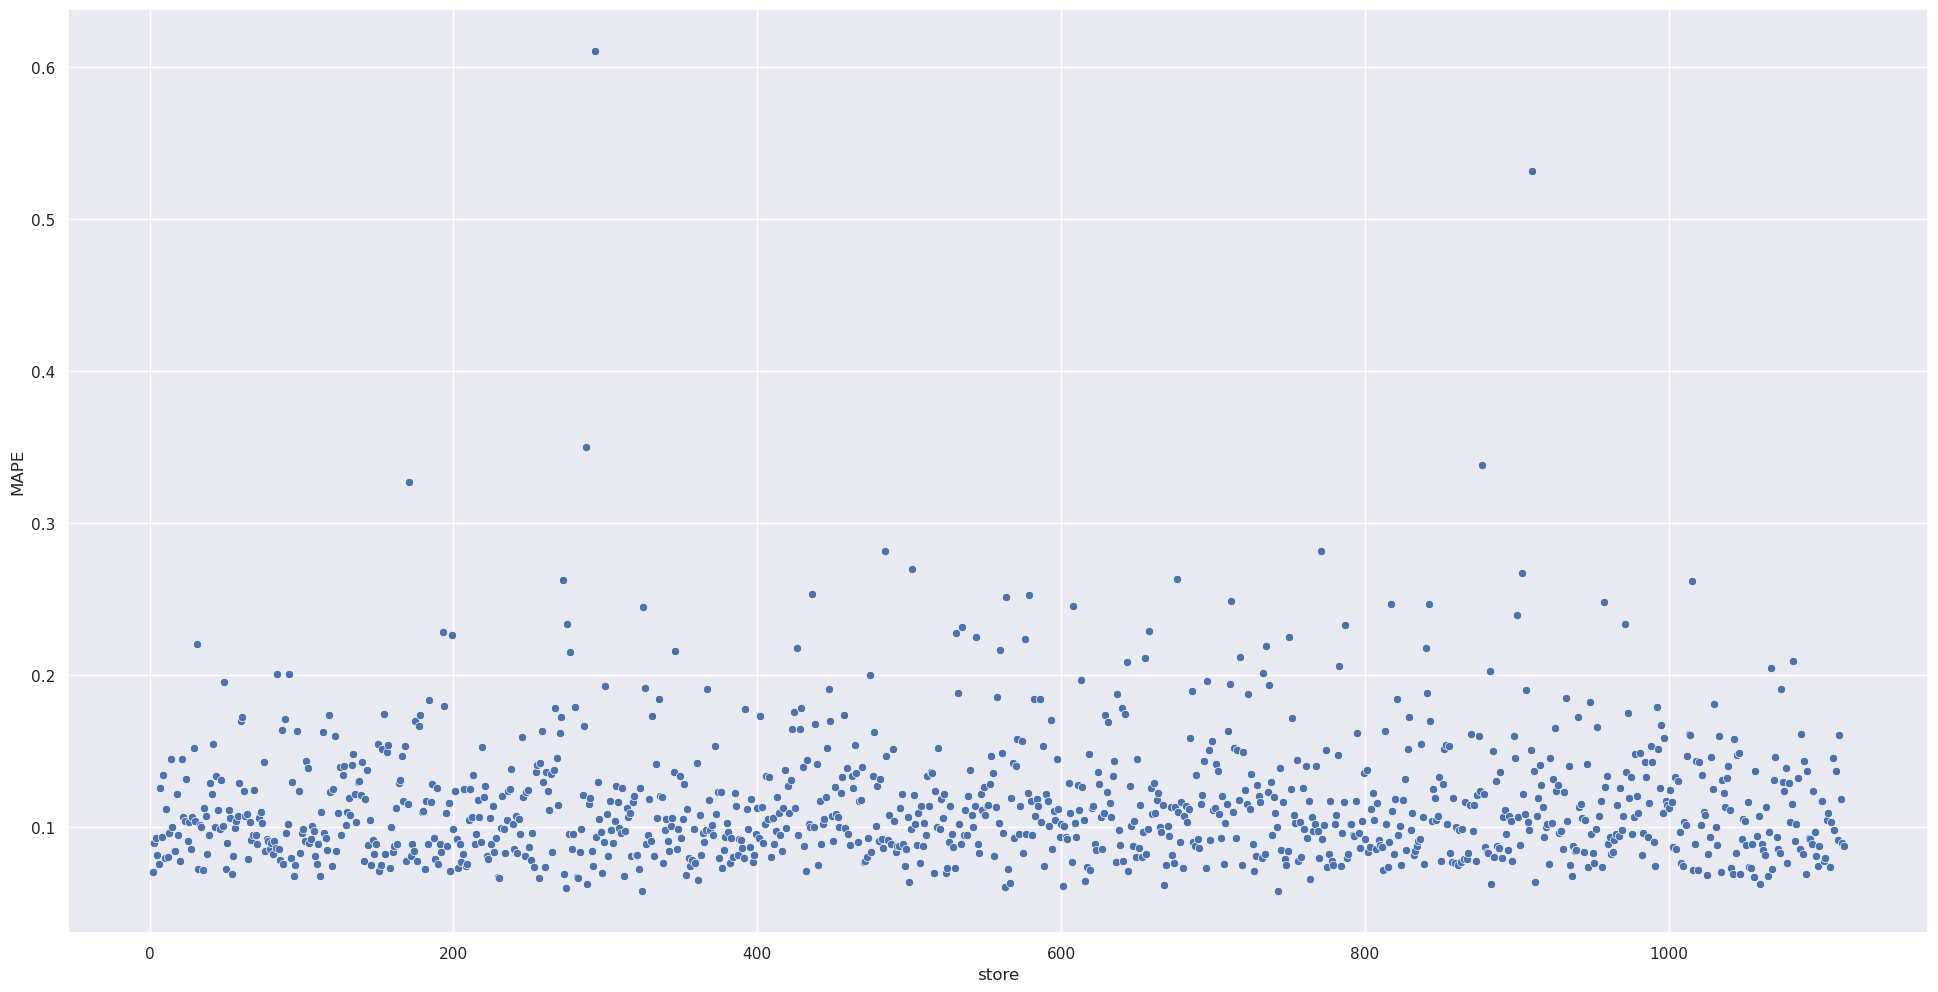

In [95]:
plt.figure()

sns.scatterplot(x='store', y='MAPE', data=df9_1)

plt.show()

In [96]:
df9_1.sort_values(by='MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
292,293,232694.20,229276.33,236112.08,3417.88,0.61
909,910,235696.59,227635.91,243757.28,8060.68,0.53
286,287,309694.06,308754.56,310633.57,939.51,0.35
876,877,244026.17,239950.95,248101.39,4075.22,0.34
170,171,296683.69,295376.47,297990.90,1307.22,0.33


### 9.2) Total Performance

In [97]:
df9_1[['predictions', 'worst_scenario', 'best_scenario']].sum(axis=0).map(lambda x: f'${x:,.2f}')\
    .reset_index().rename(columns={'index': 'Scenario', 0: 'Total'})

,Scenario,Total
0,predictions,"$286,828,352.00"
1,worst_scenario,"$285,804,949.65"
2,best_scenario,"$287,516,602.94"


### 9.3) Machine Learning Performance

In [98]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

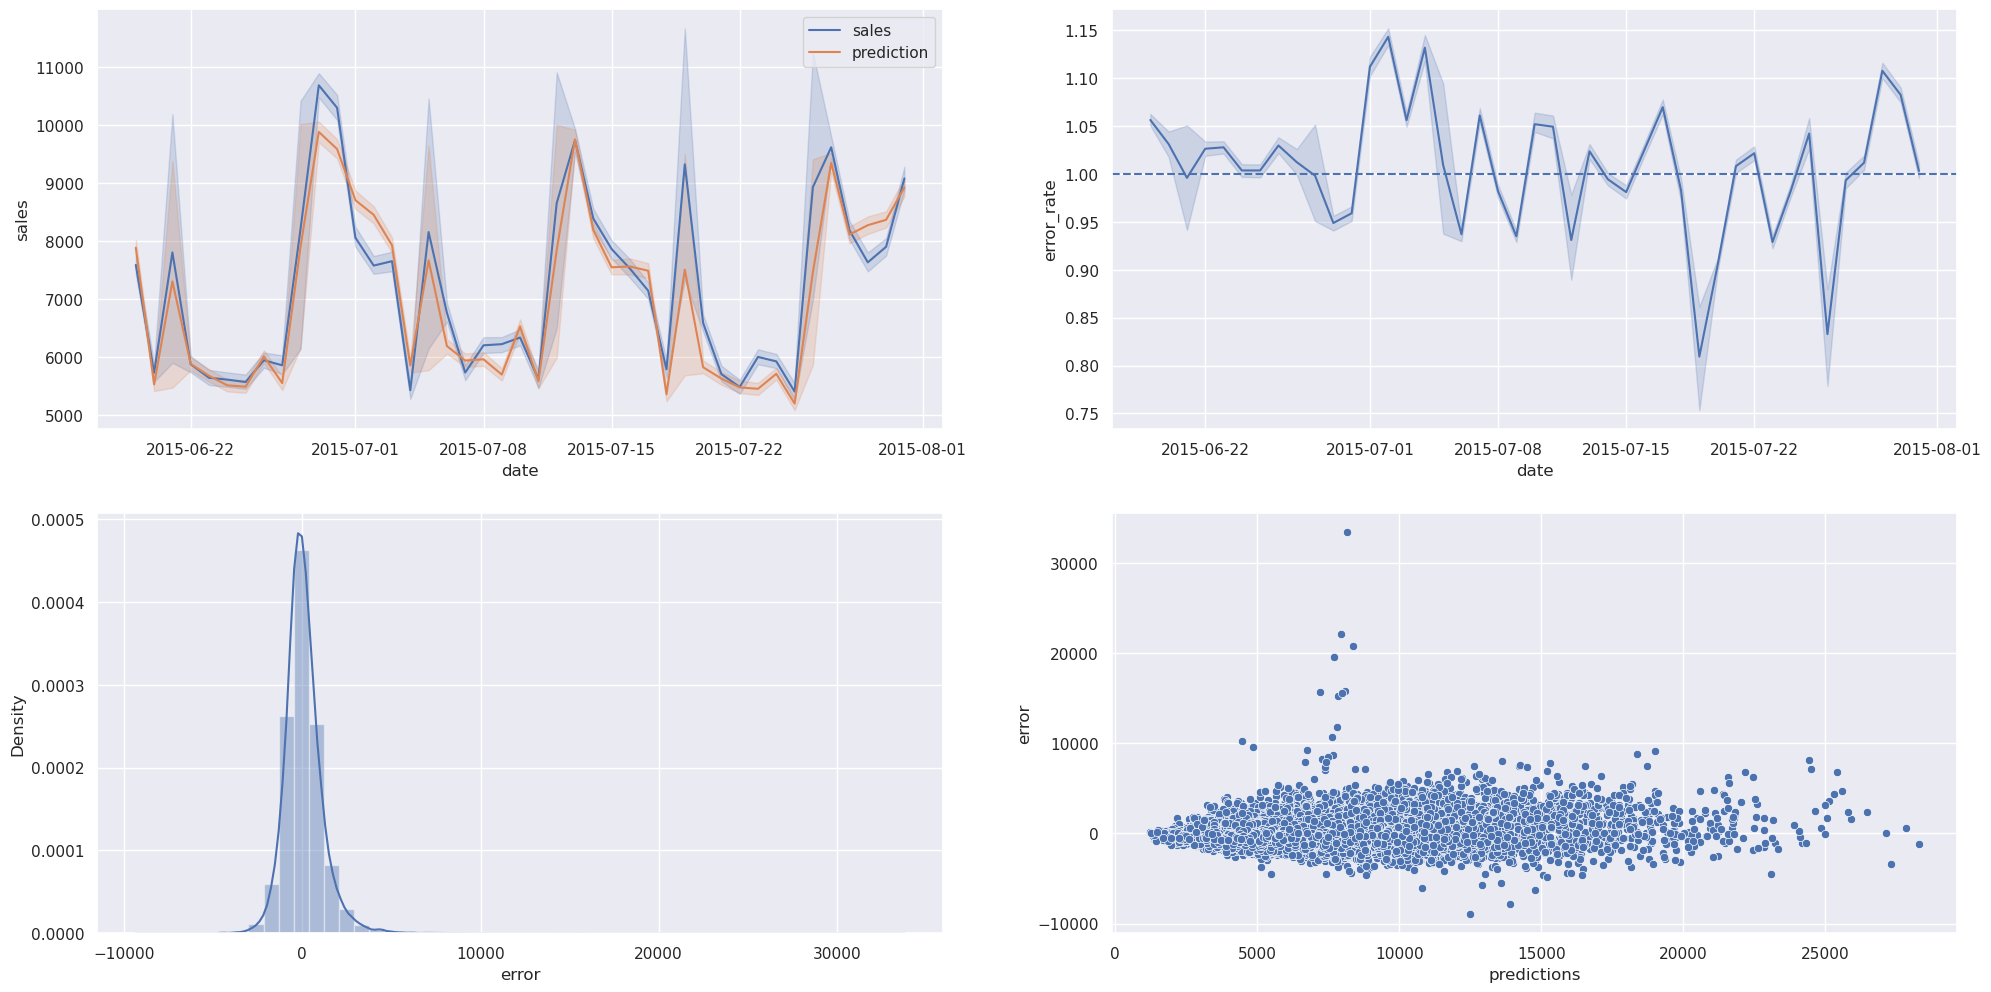

In [99]:
plt.subplot(2, 2, 1)

sns.lineplot(x='date', y='sales', data=df9, label='sales')
sns.lineplot(x='date', y='predictions', data=df9, label='prediction')

plt.subplot(2, 2, 2)

sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(y=1, color='b', linestyle='--')

plt.subplot(2, 2, 3)

sns.distplot(df9['error'])

plt.subplot(2, 2, 4)

sns.scatterplot(x='predictions', y='error', data=df9)

plt.show()

# 10) Deploy do modelo em Produção

In [100]:
pwd = os.getcwd()

# Save Trained Model
pickle.dump( final_model_tuned, open( f'{pwd}/model/model_rossmann.pkl', 'wb' ) )

### 10.1) Rosmann Class

The code for this cell is in -> `api/rossmann/Rossmann.py`

### 10.2) API Handler

The code for this cell is in -> **`api/handler.py`**

### 10.3) API Tester

In [2]:
df_test_raw = pd.read_csv('data/test.csv')
df_store_raw = pd.read_csv('data/store.csv')

# merge test + store datasets
df_test = df_test_raw.merge(df_store_raw, how='left', on='Store')

In [3]:
# choose store for prediction
df_test = df_test.loc[df_test['Store'].isin([12, 22, 24]), :]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isna()]
df_test = df_test.drop(columns='Id')

In [4]:
# convert dataframe to JSON
data = json.dumps(df_test.to_dict(orient='records'))

In [5]:
# API Call
# url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-sales-forecast.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 500


In [7]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [8]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,day,month,year,week_of_year,year_week,competition_open_since,competition_duration,promo2_since,promo_time_week,month_map,is_promo,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,a,extended,1070.00,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",17,9,2015,38,2015-37,2015-09-01T00:00:00.000Z,1,2010-03-22T00:00:00.000Z,286,Sep,False,8870.43
1,22,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,a,basic,1040.00,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",17,9,2015,38,2015-37,2015-09-01T00:00:00.000Z,1,2012-05-21T00:00:00.000Z,173,Sep,False,5788.64
2,24,4,2015-09-17T00:00:00.000Z,1.00,1,regular_day,0,a,extended,4590.00,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",17,9,2015,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,Sep,False,11467.78
3,12,3,2015-09-16T00:00:00.000Z,1.00,1,regular_day,0,a,extended,1070.00,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",16,9,2015,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,Sep,False,8791.02
4,22,3,2015-09-16T00:00:00.000Z,1.00,1,regular_day,0,a,basic,1040.00,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",16,9,2015,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,Sep,False,5692.31


In [9]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print(f"Store Number {d2.loc[i, 'store']} will sell ${d2.loc[i, 'prediction']} in the next 6 weeks")

Store Number 12 will sell $275711.8886718748 in the next 6 weeks
Store Number 22 will sell $170652.9143066404 in the next 6 weeks
Store Number 24 will sell $338928.4047851564 in the next 6 weeks
